# Fraud Data Exploratory Data Analysis (EDA)

This notebook performs comprehensive EDA on the fraud dataset to understand:
1. **Data Overview**: Structure, schema, and basic statistics
2. **Data Quality**: Missing values, duplicates, and data integrity
3. **Fraud Analysis**: Distribution, patterns, and characteristics
4. **Temporal Analysis**: Time-based fraud trends and seasonality
5. **Geographic Analysis**: Location-based fraud patterns
6. **Merchant Analysis**: Fraud by merchant categories and types
7. **Value Analysis**: Transaction amounts and fraud value distribution
8. **Feature Engineering**: Creating meaningful features for analysis
9. **Statistical Insights**: Key findings and business implications

## Dataset Information
- **Source**: Credit card fraud detection dataset
- **Size**: ~1.8M transactions (1.3M train + 0.6M test)
- **Features**: 23 columns including transaction details, merchant info, and fraud labels
- **Time Period**: 2019-2020 (based on unix timestamps)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Configure plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

print("📊 Fraud Data EDA - Enhanced Analysis")
print("=" * 50)


📊 Fraud Data EDA - Enhanced Analysis


## 1. Data Loading and Initial Overview


In [2]:
# Load fraud data from CSV files
print("🔄 LOADING FRAUD DATA")
print("-" * 30)

# Define paths
data_dir = Path("../dataset")
train_file = data_dir / "archive" / "fraudTrain.csv"
test_file = data_dir / "archive" / "fraudTest.csv"

print(f"📁 Data directory: {data_dir}")
print(f"📄 Train file exists: {train_file.exists()}")
print(f"📄 Test file exists: {test_file.exists()}")

# Load data with error handling
try:
    if train_file.exists():
        train_df = pd.read_csv(train_file)
        print(f"✅ Train data loaded: {train_df.shape}")
    else:
        print("❌ Train file not found!")
        train_df = None

    if test_file.exists():
        test_df = pd.read_csv(test_file)
        print(f"✅ Test data loaded: {test_df.shape}")
    else:
        print("❌ Test file not found!")
        test_df = None
        
    # Combine datasets for comprehensive analysis
    if train_df is not None and test_df is not None:
        # Add dataset identifier
        train_df['dataset'] = 'train'
        test_df['dataset'] = 'test'
        
        # Combine datasets
        combined_df = pd.concat([train_df, test_df], ignore_index=True)
        print(f"🔗 Combined dataset: {combined_df.shape}")
        
        # Basic memory usage
        memory_usage = combined_df.memory_usage(deep=True).sum() / 1024**2
        print(f"💾 Memory usage: {memory_usage:.2f} MB")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    combined_df = None


🔄 LOADING FRAUD DATA
------------------------------
📁 Data directory: ..\dataset
📄 Train file exists: True
📄 Test file exists: True
✅ Train data loaded: (1296675, 23)
✅ Test data loaded: (555719, 23)
🔗 Combined dataset: (1852394, 24)
💾 Memory usage: 1757.16 MB


## 2. Data Overview and Structure


In [3]:
if combined_df is not None:
    print("📊 DATASET OVERVIEW")
    print("=" * 50)
    
    # Basic information
    print(f"📏 Dataset shape: {combined_df.shape}")
    print(f"📋 Number of features: {combined_df.shape[1]}")
    print(f"📊 Number of observations: {combined_df.shape[0]:,}")
    
    # Dataset split
    train_count = len(combined_df[combined_df['dataset'] == 'train'])
    test_count = len(combined_df[combined_df['dataset'] == 'test'])
    print(f"🏋️ Training samples: {train_count:,} ({train_count/len(combined_df)*100:.1f}%)")
    print(f"🧪 Test samples: {test_count:,} ({test_count/len(combined_df)*100:.1f}%)")
    
    # Fraud distribution
    fraud_count = combined_df['is_fraud'].sum()
    fraud_rate = fraud_count / len(combined_df) * 100
    print(f"🚨 Fraud cases: {fraud_count:,} ({fraud_rate:.2f}%)")
    
    print("\n📋 COLUMN INFORMATION")
    print("-" * 30)
    
    # Column details
    column_info = pd.DataFrame({
        'Column': combined_df.columns,
        'Data Type': combined_df.dtypes,
        'Non-Null Count': combined_df.count(),
        'Null Count': combined_df.isnull().sum(),
        'Null %': (combined_df.isnull().sum() / len(combined_df) * 100).round(2),
        'Unique Values': combined_df.nunique()
    })
    
    print(column_info.to_string(index=False))
    
    print("\n🔍 SAMPLE DATA")
    print("-" * 20)
    display(combined_df.head(10))
    
    print("\n📈 STATISTICAL SUMMARY")
    print("-" * 30)
    display(combined_df.describe(include='all'))


📊 DATASET OVERVIEW
📏 Dataset shape: (1852394, 24)
📋 Number of features: 24
📊 Number of observations: 1,852,394
🏋️ Training samples: 1,296,675 (70.0%)
🧪 Test samples: 555,719 (30.0%)
🚨 Fraud cases: 9,651 (0.52%)

📋 COLUMN INFORMATION
------------------------------
               Column Data Type  Non-Null Count  Null Count  Null %  Unique Values
           Unnamed: 0     int64         1852394           0     0.0        1296675
trans_date_trans_time    object         1852394           0     0.0        1819551
               cc_num     int64         1852394           0     0.0            999
             merchant    object         1852394           0     0.0            693
             category    object         1852394           0     0.0             14
                  amt   float64         1852394           0     0.0          60616
                first    object         1852394           0     0.0            355
                 last    object         1852394           0     0.0     

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,dataset
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train
5,5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,...,-75.2045,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0,train
6,6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,...,-100.9893,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0,train
7,7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,...,-78.6003,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0,train
8,8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,...,-79.6607,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0,train
9,9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,...,-87.3490,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.179198,-87.485381,0,train



📈 STATISTICAL SUMMARY
------------------------------


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,dataset
count,1.852394e+06,1852394,1.852394e+06,1852394,1852394,1.852394e+06,1852394,1852394,1852394,1852394,...,1.852394e+06,1.852394e+06,1852394,1852394,1852394,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1852394
unique,NaN,1819551,NaN,693,14,NaN,355,486,2,999,...,NaN,NaN,497,984,1852394,NaN,NaN,NaN,NaN,2
top,NaN,2019-04-22 16:02:01,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,908 Brooks Brook,...,NaN,NaN,Film/video editor,1977-03-23,1765bb45b3aa3224b4cdcb6e7a96cee3,NaN,NaN,NaN,NaN,train
freq,NaN,4,NaN,6262,188029,NaN,38112,40940,1014749,4392,...,NaN,NaN,13898,8044,1,NaN,NaN,NaN,NaN,1296675
mean,5.371934e+05,NaN,4.173860e+17,NaN,NaN,7.006357e+01,NaN,NaN,NaN,NaN,...,-9.022783e+01,8.864367e+04,NaN,NaN,NaN,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,NaN
std,3.669110e+05,NaN,1.309115e+18,NaN,NaN,1.592540e+02,NaN,NaN,NaN,NaN,...,1.374789e+01,3.014876e+05,NaN,NaN,NaN,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,NaN
min,0.000000e+00,NaN,6.041621e+10,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,...,-1.656723e+02,2.300000e+01,NaN,NaN,NaN,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,NaN
25%,2.315490e+05,NaN,1.800429e+14,NaN,NaN,9.640000e+00,NaN,NaN,NaN,NaN,...,-9.679800e+01,7.410000e+02,NaN,NaN,NaN,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,NaN
50%,4.630980e+05,NaN,3.521417e+15,NaN,NaN,4.745000e+01,NaN,NaN,NaN,NaN,...,-8.747690e+01,2.443000e+03,NaN,NaN,NaN,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,NaN
75%,8.335758e+05,NaN,4.642255e+15,NaN,NaN,8.310000e+01,NaN,NaN,NaN,NaN,...,-8.015800e+01,2.032800e+04,NaN,NaN,NaN,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,NaN


## 3. Data Quality Analysis


In [4]:
if combined_df is not None:
    print("🔍 COMPREHENSIVE DATA QUALITY ANALYSIS")
    print("=" * 50)
    
    # 1. MISSING VALUES ANALYSIS
    print("📊 MISSING VALUES ANALYSIS")
    print("-" * 30)
    
    missing_data = combined_df.isnull().sum()
    missing_percent = (missing_data / len(combined_df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing %': missing_percent.values
    }).sort_values('Missing %', ascending=False)
    
    print("Missing values by column:")
    print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))
    
    if missing_df['Missing Count'].sum() == 0:
        print("✅ No missing values found!")
    else:
        print(f"\n🚨 Total missing values: {missing_df['Missing Count'].sum():,}")
        print(f"📊 Columns with missing data: {len(missing_df[missing_df['Missing Count'] > 0])}")
    
    # 2. DUPLICATE ANALYSIS
    print(f"\n🔄 DUPLICATE ANALYSIS")
    print("-" * 25)
    
    # Row-level duplicates
    row_duplicates = combined_df.duplicated().sum()
    print(f"Duplicate rows: {row_duplicates:,}")
    
    # Column-specific duplicates
    if 'trans_num' in combined_df.columns:
        duplicate_trans = combined_df['trans_num'].duplicated().sum()
        print(f"Duplicate transaction numbers: {duplicate_trans:,}")
    
    if 'cc_num' in combined_df.columns:
        duplicate_cc = combined_df['cc_num'].duplicated().sum()
        print(f"Duplicate credit card numbers: {duplicate_cc:,}")
    
    # 3. DATA TYPE CONSISTENCY
    print(f"\n📋 DATA TYPE ANALYSIS")
    print("-" * 25)
    
    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"🔢 Numeric columns: {len(numeric_cols)}")
    print(f"📝 Categorical columns: {len(categorical_cols)}")
    
    # Check for mixed data types
    print(f"\n🔍 MIXED DATA TYPE DETECTION")
    print("-" * 35)
    
    for col in categorical_cols:
        if col in combined_df.columns:
            # Check if categorical column contains numeric values
            try:
                numeric_count = pd.to_numeric(combined_df[col], errors='coerce').notna().sum()
                if numeric_count > 0:
                    print(f"⚠️ {col}: {numeric_count:,} numeric values in categorical column")
            except:
                pass
    
    # 4. INVALID DATA DETECTION
    print(f"\n⚠️ INVALID DATA DETECTION")
    print("-" * 30)
    
    # Amount validation
    if 'amt' in combined_df.columns:
        print(f"💰 AMOUNT VALIDATION:")
        
        # Negative amounts
        negative_amt = (combined_df['amt'] < 0).sum()
        print(f"  • Negative amounts: {negative_amt:,}")
        
        # Zero amounts
        zero_amt = (combined_df['amt'] == 0).sum()
        print(f"  • Zero amounts: {zero_amt:,}")
        
        # Very high amounts (potential outliers)
        high_amt = (combined_df['amt'] > 10000).sum()
        print(f"  • Very high amounts (>$10k): {high_amt:,}")
        
        # Amount statistics
        amt_stats = combined_df['amt'].describe()
        print(f"  • Amount range: ${amt_stats['min']:.2f} - ${amt_stats['max']:.2f}")
        print(f"  • Amount mean: ${amt_stats['mean']:.2f}")
        print(f"  • Amount std: ${amt_stats['std']:.2f}")
        
        # Amount outliers (using IQR method)
        Q1 = combined_df['amt'].quantile(0.25)
        Q3 = combined_df['amt'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((combined_df['amt'] < lower_bound) | (combined_df['amt'] > upper_bound)).sum()
        print(f"  • Statistical outliers: {outliers:,}")
    
    # Date validation
    if 'trans_date_trans_time' in combined_df.columns:
        print(f"\n📅 DATE VALIDATION:")
        
        try:
            # Convert to datetime
            combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'])
            
            # Invalid dates
            invalid_dates = combined_df['trans_date_trans_time'].isnull().sum()
            print(f"  • Invalid dates: {invalid_dates:,}")
            
            # Date range
            min_date = combined_df['trans_date_trans_time'].min()
            max_date = combined_df['trans_date_trans_time'].max()
            print(f"  • Date range: {min_date} to {max_date}")
            
            # Future dates (if any)
            future_dates = (combined_df['trans_date_trans_time'] > pd.Timestamp.now()).sum()
            print(f"  • Future dates: {future_dates:,}")
            
            # Very old dates (before 2000)
            old_dates = (combined_df['trans_date_trans_time'] < '2000-01-01').sum()
            print(f"  • Very old dates (<2000): {old_dates:,}")
            
        except Exception as e:
            print(f"  • Date parsing error: {e}")
    
    # Geographic validation
    if 'lat' in combined_df.columns and 'long' in combined_df.columns:
        print(f"\n🌍 GEOGRAPHIC VALIDATION:")
        
        # Invalid coordinates
        invalid_lat = ((combined_df['lat'] < -90) | (combined_df['lat'] > 90)).sum()
        invalid_long = ((combined_df['long'] < -180) | (combined_df['long'] > 180)).sum()
        print(f"  • Invalid latitude: {invalid_lat:,}")
        print(f"  • Invalid longitude: {invalid_long:,}")
        
        # Zero coordinates
        zero_lat = (combined_df['lat'] == 0).sum()
        zero_long = (combined_df['long'] == 0).sum()
        print(f"  • Zero latitude: {zero_lat:,}")
        print(f"  • Zero longitude: {zero_long:,}")
    
    # 5. CATEGORICAL DATA VALIDATION
    print(f"\n📝 CATEGORICAL DATA VALIDATION")
    print("-" * 35)
    
    # Check for unexpected values in categorical columns
    categorical_columns = ['category', 'merchant', 'state', 'gender']
    
    for col in categorical_columns:
        if col in combined_df.columns:
            print(f"\n{col.upper()}:")
            
            # Unique values count
            unique_count = combined_df[col].nunique()
            print(f"  • Unique values: {unique_count:,}")
            
            # Most frequent values
            top_values = combined_df[col].value_counts().head(5)
            print(f"  • Top 5 values:")
            for value, count in top_values.items():
                print(f"    - {value}: {count:,}")
            
            # Check for empty strings
            empty_strings = (combined_df[col] == '').sum()
            if empty_strings > 0:
                print(f"  • Empty strings: {empty_strings:,}")
            
            # Check for whitespace-only values
            whitespace_only = combined_df[col].str.strip().eq('').sum()
            if whitespace_only > 0:
                print(f"  • Whitespace-only values: {whitespace_only:,}")
    
    # 6. FRAUD-SPECIFIC VALIDATION
    print(f"\n🚨 FRAUD-SPECIFIC VALIDATION")
    print("-" * 35)
    
    if 'is_fraud' in combined_df.columns:
        # Fraud label validation
        fraud_values = combined_df['is_fraud'].value_counts()
        print(f"Fraud label distribution:")
        for value, count in fraud_values.items():
            print(f"  • {value}: {count:,}")
        
        # Check for invalid fraud labels
        invalid_fraud = combined_df['is_fraud'].isin([0, 1]).sum()
        if invalid_fraud < len(combined_df):
            print(f"  • Invalid fraud labels: {len(combined_df) - invalid_fraud:,}")
        
        # Fraud rate validation
        fraud_rate = combined_df['is_fraud'].mean() * 100
        print(f"  • Overall fraud rate: {fraud_rate:.4f}%")
        
        if fraud_rate > 50:
            print(f"  ⚠️ WARNING: Unusually high fraud rate!")
        elif fraud_rate < 0.1:
            print(f"  ⚠️ WARNING: Very low fraud rate - check data quality!")
    
    # 7. DATA CONSISTENCY CHECKS
    print(f"\n🔍 DATA CONSISTENCY CHECKS")
    print("-" * 35)
    
    # Check for logical inconsistencies
    if 'amt' in combined_df.columns and 'is_fraud' in combined_df.columns:
        # Fraud transactions with zero amount
        zero_fraud = ((combined_df['amt'] == 0) & (combined_df['is_fraud'] == 1)).sum()
        print(f"  • Fraud transactions with zero amount: {zero_fraud:,}")
        
        # Very high amount legitimate transactions
        high_legit = ((combined_df['amt'] > 5000) & (combined_df['is_fraud'] == 0)).sum()
        print(f"  • High-value legitimate transactions (>$5k): {high_legit:,}")
    
    # Check for temporal inconsistencies
    if 'trans_date_trans_time' in combined_df.columns and 'unix_time' in combined_df.columns:
        try:
            # Convert unix time to datetime
            unix_datetime = pd.to_datetime(combined_df['unix_time'], unit='s')
            time_diff = (combined_df['trans_date_trans_time'] - unix_datetime).abs()
            inconsistent_time = (time_diff > pd.Timedelta(hours=1)).sum()
            print(f"  • Time inconsistencies (>1hr diff): {inconsistent_time:,}")
        except:
            print(f"  • Time consistency check failed")
    
    # 8. DATA QUALITY SCORE
    print(f"\n📊 DATA QUALITY SCORE")
    print("-" * 25)
    
    # Calculate overall data quality score
    total_records = len(combined_df)
    total_issues = 0
    
    # Missing values penalty
    missing_penalty = missing_df['Missing Count'].sum()
    total_issues += missing_penalty
    
    # Duplicate penalty
    total_issues += row_duplicates
    
    # Invalid data penalty
    if 'amt' in combined_df.columns:
        total_issues += negative_amt + zero_amt
    if 'trans_date_trans_time' in combined_df.columns:
        try:
            total_issues += combined_df['trans_date_trans_time'].isnull().sum()
        except:
            pass
    
    # Calculate quality score
    quality_score = max(0, 100 - (total_issues / total_records * 100))
    
    print(f"Total records: {total_records:,}")
    print(f"Total issues: {total_issues:,}")
    print(f"Data quality score: {quality_score:.2f}/100")
    
    if quality_score >= 95:
        print("✅ EXCELLENT data quality!")
    elif quality_score >= 90:
        print("✅ GOOD data quality")
    elif quality_score >= 80:
        print("⚠️ FAIR data quality - some issues detected")
    else:
        print("🚨 POOR data quality - significant issues detected")
    
    # 9. RECOMMENDATIONS
    print(f"\n💡 DATA QUALITY RECOMMENDATIONS")
    print("-" * 40)
    
    if missing_df['Missing Count'].sum() > 0:
        print("1. 🚫 Address missing values:")
        high_missing = missing_df[missing_df['Missing %'] > 5]
        for _, row in high_missing.iterrows():
            print(f"   • {row['Column']}: {row['Missing %']:.2f}% missing")
    
    if row_duplicates > 0:
        print("2. 🔄 Remove duplicate records")
    
    if 'amt' in combined_df.columns:
        if negative_amt > 0:
            print("3. 💰 Investigate negative amounts")
        if zero_amt > 0:
            print("4. 💰 Review zero-amount transactions")
        if outliers > 0:
            print("5. 📊 Review statistical outliers")
    
    if 'trans_date_trans_time' in combined_df.columns:
        try:
            if combined_df['trans_date_trans_time'].isnull().sum() > 0:
                print("6. 📅 Fix invalid dates")
        except:
            pass
    
    print("7. 🔍 Implement data validation rules")
    print("8. 📊 Set up automated data quality monitoring")
    print("9. 🔄 Regular data quality audits")
    print("10. 📈 Track data quality metrics over time")


🔍 COMPREHENSIVE DATA QUALITY ANALYSIS
📊 MISSING VALUES ANALYSIS
------------------------------
Missing values by column:
Empty DataFrame
Columns: [Column, Missing Count, Missing %]
Index: []
✅ No missing values found!

🔄 DUPLICATE ANALYSIS
-------------------------
Duplicate rows: 0
Duplicate transaction numbers: 0
Duplicate credit card numbers: 1,851,395

📋 DATA TYPE ANALYSIS
-------------------------
🔢 Numeric columns: 11
📝 Categorical columns: 13

🔍 MIXED DATA TYPE DETECTION
-----------------------------------
⚠️ trans_num: 2 numeric values in categorical column

⚠️ INVALID DATA DETECTION
------------------------------
💰 AMOUNT VALIDATION:
  • Negative amounts: 0
  • Zero amounts: 0
  • Very high amounts (>$10k): 46
  • Amount range: $1.00 - $28948.90
  • Amount mean: $70.06
  • Amount std: $159.25
  • Statistical outliers: 95,054

📅 DATE VALIDATION:
  • Invalid dates: 0
  • Date range: 2019-01-01 00:00:18 to 2020-12-31 23:59:34
  • Future dates: 0
  • Very old dates (<2000): 0

🌍 G


📊 DATA QUALITY VISUALIZATIONS
-----------------------------------


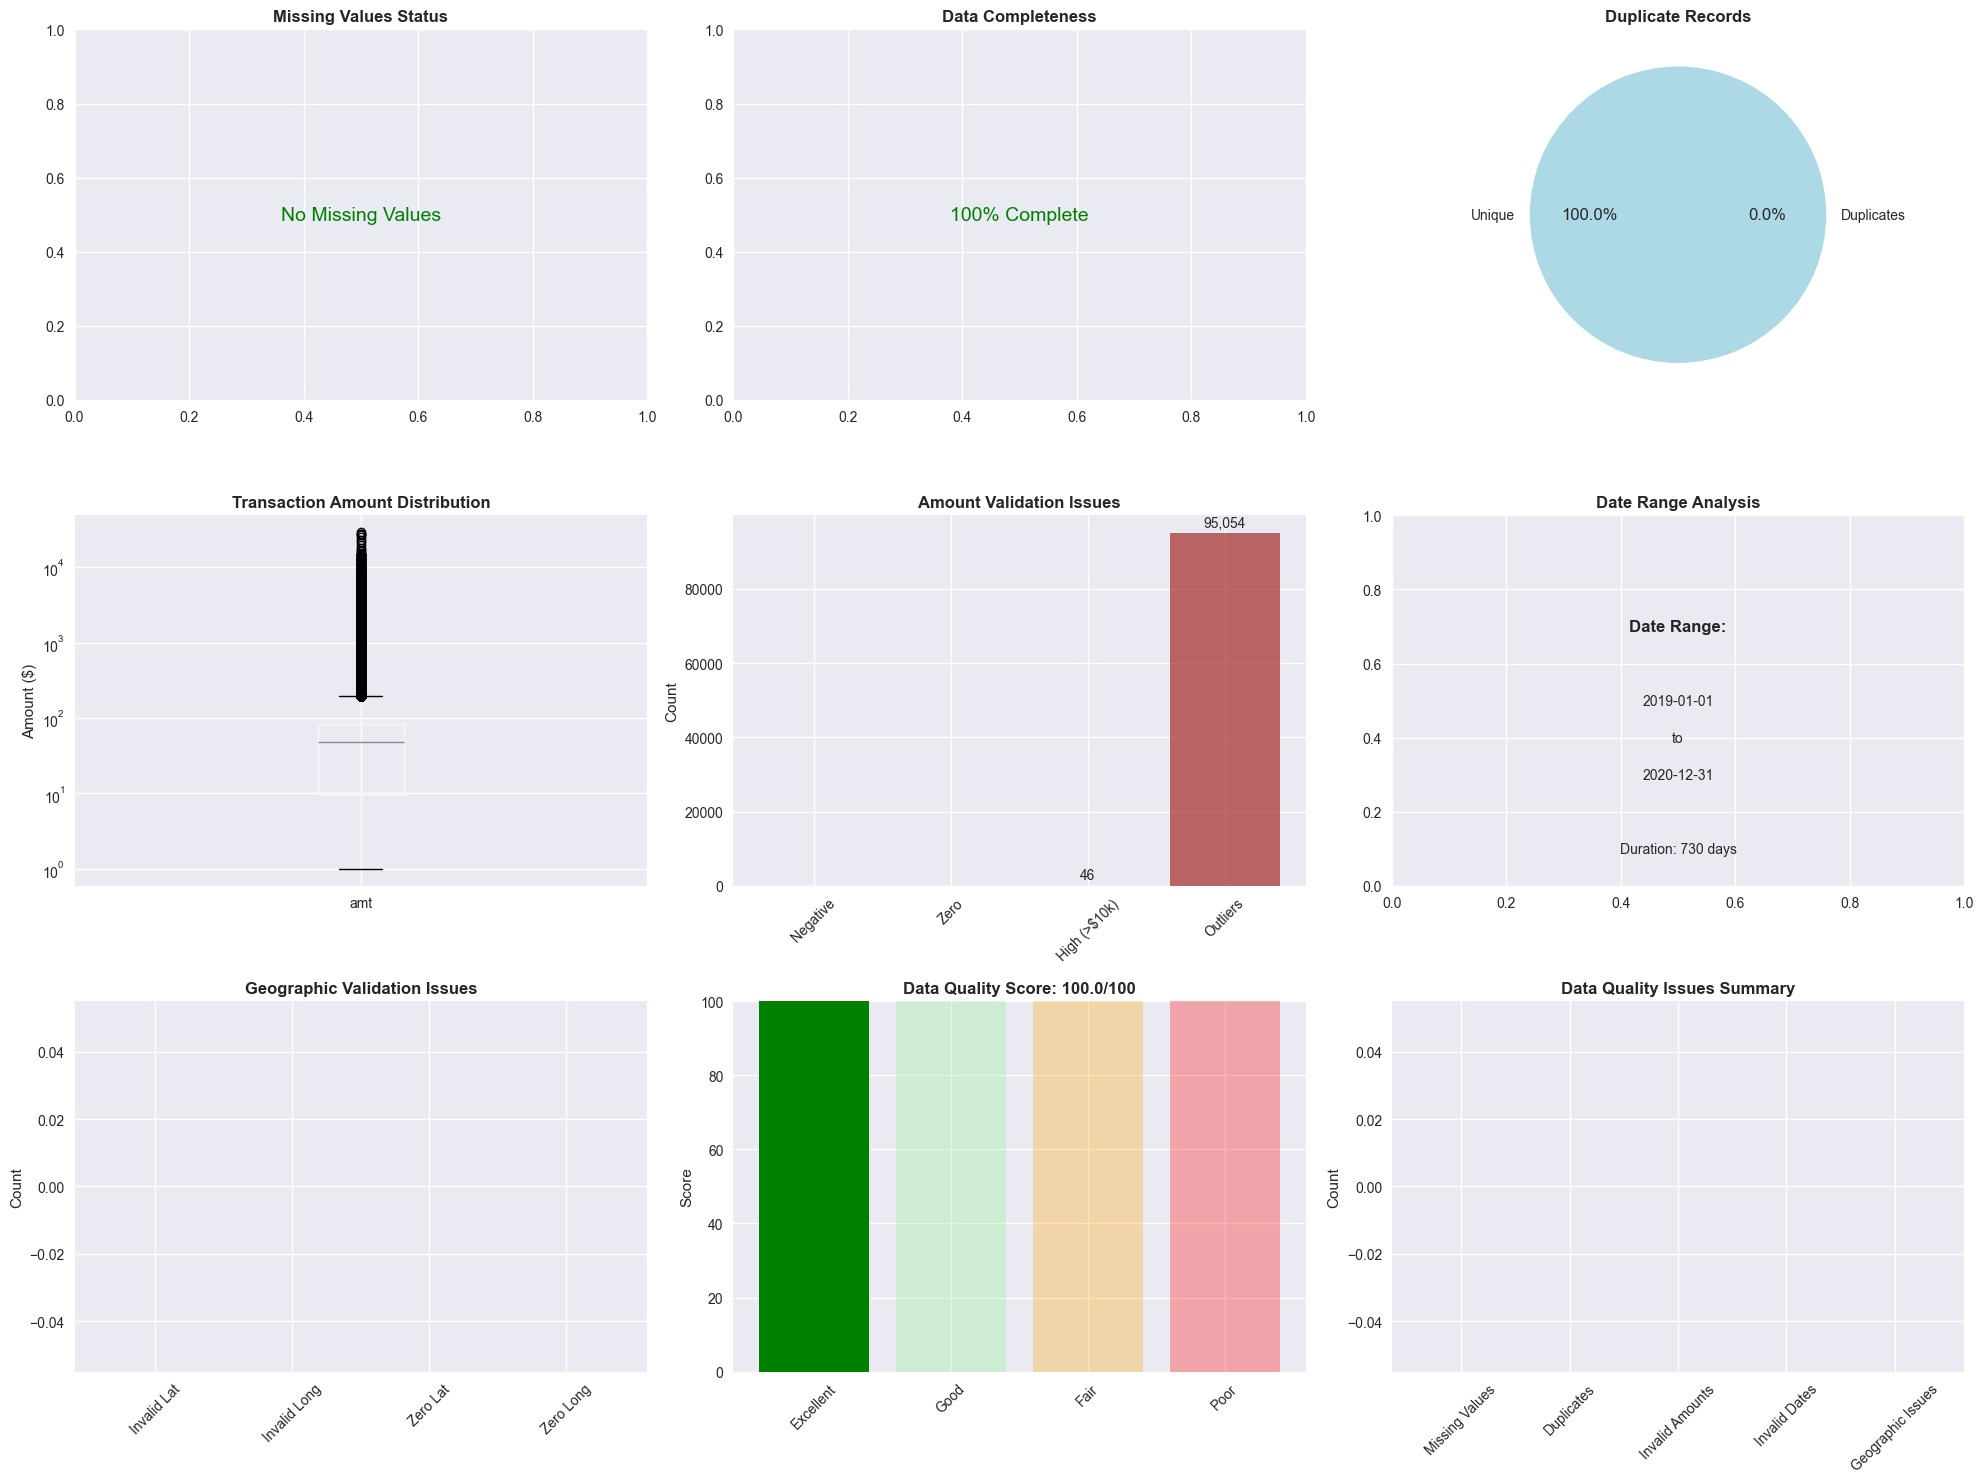


📋 DETAILED DATA QUALITY REPORT
📊 DATASET OVERVIEW:
  • Total records: 1,852,394
  • Total columns: 24
  • Data quality score: 100.00/100
  • Overall status: ✅ EXCELLENT

🔍 ISSUE BREAKDOWN:
  • Missing Values: ✅ None
  • Duplicates: ✅ None
  • Invalid Amounts: ✅ None
  • Invalid Dates: ✅ None
  • Geographic Issues: ✅ None

📈 RECOMMENDATIONS:
  • Continue current data quality practices
  • Implement automated monitoring
  • Regular quality audits

✅ Data quality analysis completed!
📊 Generated 5 quality metrics
📈 Created comprehensive visualizations
💡 Provided actionable recommendations


In [ ]:
# 10. DATA QUALITY VISUALIZATIONS
print(f"\n📊 DATA QUALITY VISUALIZATIONS")
print("-" * 35)

# Create comprehensive data quality visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Missing values heatmap
if missing_df['Missing Count'].sum() > 0:
    missing_pivot = missing_df[missing_df['Missing Count'] > 0].set_index('Column')['Missing %']
    missing_pivot.plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
    axes[0,0].set_title('Missing Values by Column', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Missing %')
    axes[0,0].tick_params(axis='x', rotation=45)
else:
    axes[0,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                  transform=axes[0,0].transAxes, fontsize=14, color='green')
    axes[0,0].set_title('Missing Values Status', fontsize=12, fontweight='bold')

# 2. Data completeness pie chart
complete_records = total_records - missing_df['Missing Count'].sum()
incomplete_records = missing_df['Missing Count'].sum()

if incomplete_records > 0:
    axes[0,1].pie([complete_records, incomplete_records], 
                 labels=['Complete', 'Incomplete'], 
                 autopct='%1.1f%%', colors=['green', 'red'])
    axes[0,1].set_title('Data Completeness', fontsize=12, fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, '100% Complete', ha='center', va='center', 
                  transform=axes[0,1].transAxes, fontsize=14, color='green')
    axes[0,1].set_title('Data Completeness', fontsize=12, fontweight='bold')

# 3. Duplicate analysis
duplicate_data = [row_duplicates, total_records - row_duplicates]
duplicate_labels = ['Duplicates', 'Unique']
axes[0,2].pie(duplicate_data, labels=duplicate_labels, autopct='%1.1f%%', 
             colors=['orange', 'lightblue'])
axes[0,2].set_title('Duplicate Records', fontsize=12, fontweight='bold')

# 4. Amount distribution with outliers
if 'amt' in combined_df.columns:
    # Box plot for amount distribution
    combined_df.boxplot(column='amt', ax=axes[1,0])
    axes[1,0].set_title('Transaction Amount Distribution', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('Amount ($)')
    axes[1,0].set_yscale('log')
    
    # Amount validation issues
    amt_issues = [negative_amt, zero_amt, high_amt, outliers]
    amt_labels = ['Negative', 'Zero', 'High (>$10k)', 'Outliers']
    amt_colors = ['red', 'orange', 'purple', 'brown']
    
    bars = axes[1,1].bar(amt_labels, amt_issues, color=amt_colors, alpha=0.7)
    axes[1,1].set_title('Amount Validation Issues', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, amt_issues):
        if value > 0:
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(amt_issues)*0.01,
                          f'{value:,}', ha='center', va='bottom', fontsize=10)

# 5. Date validation
if 'trans_date_trans_time' in combined_df.columns:
    try:
        # Date range visualization
        date_range = combined_df['trans_date_trans_time'].max() - combined_df['trans_date_trans_time'].min()
        axes[1,2].text(0.5, 0.7, f'Date Range:', ha='center', va='center', 
                      transform=axes[1,2].transAxes, fontsize=12, fontweight='bold')
        axes[1,2].text(0.5, 0.5, f'{combined_df["trans_date_trans_time"].min().strftime("%Y-%m-%d")}', 
                      ha='center', va='center', transform=axes[1,2].transAxes, fontsize=10)
        axes[1,2].text(0.5, 0.4, f'to', ha='center', va='center', 
                      transform=axes[1,2].transAxes, fontsize=10)
        axes[1,2].text(0.5, 0.3, f'{combined_df["trans_date_trans_time"].max().strftime("%Y-%m-%d")}', 
                      ha='center', va='center', transform=axes[1,2].transAxes, fontsize=10)
        axes[1,2].text(0.5, 0.1, f'Duration: {date_range.days} days', ha='center', va='center', 
                      transform=axes[1,2].transAxes, fontsize=10)
        axes[1,2].set_title('Date Range Analysis', fontsize=12, fontweight='bold')
    except:
        axes[1,2].text(0.5, 0.5, 'Date Analysis\nNot Available', ha='center', va='center', 
                      transform=axes[1,2].transAxes, fontsize=12)
        axes[1,2].set_title('Date Range Analysis', fontsize=12, fontweight='bold')

# 6. Geographic validation
if 'lat' in combined_df.columns and 'long' in combined_df.columns:
    geo_issues = [invalid_lat, invalid_long, zero_lat, zero_long]
    geo_labels = ['Invalid Lat', 'Invalid Long', 'Zero Lat', 'Zero Long']
    geo_colors = ['red', 'red', 'orange', 'orange']
    
    bars = axes[2,0].bar(geo_labels, geo_issues, color=geo_colors, alpha=0.7)
    axes[2,0].set_title('Geographic Validation Issues', fontsize=12, fontweight='bold')
    axes[2,0].set_ylabel('Count')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars, geo_issues):
        if value > 0:
            axes[2,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(geo_issues)*0.01,
                          f'{value:,}', ha='center', va='bottom', fontsize=10)
else:
    axes[2,0].text(0.5, 0.5, 'Geographic Data\nNot Available', ha='center', va='center', 
                  transform=axes[2,0].transAxes, fontsize=12)
    axes[2,0].set_title('Geographic Validation', fontsize=12, fontweight='bold')

# 7. Data quality score visualization
quality_levels = ['Excellent', 'Good', 'Fair', 'Poor']
quality_thresholds = [95, 90, 80, 0]
quality_colors = ['green', 'lightgreen', 'orange', 'red']

# Find quality level
if quality_score >= 95:
    level = 0
elif quality_score >= 90:
    level = 1
elif quality_score >= 80:
    level = 2
else:
    level = 3

# Create quality score bar
quality_bars = axes[2,1].bar(quality_levels, [100, 100, 100, 100], color=quality_colors, alpha=0.3)
quality_bars[level].set_alpha(1.0)
axes[2,1].bar(quality_levels[level], quality_score, color=quality_colors[level], alpha=0.8)
axes[2,1].set_title(f'Data Quality Score: {quality_score:.1f}/100', fontsize=12, fontweight='bold')
axes[2,1].set_ylabel('Score')
axes[2,1].set_ylim(0, 100)
axes[2,1].tick_params(axis='x', rotation=45)

# 8. Issue summary
issues_summary = {
    'Missing Values': missing_df['Missing Count'].sum(),
    'Duplicates': row_duplicates,
    'Invalid Amounts': negative_amt + zero_amt if 'amt' in combined_df.columns else 0,
    'Invalid Dates': invalid_dates if 'trans_date_trans_time' in combined_df.columns else 0,
    'Geographic Issues': invalid_lat + invalid_long if 'lat' in combined_df.columns else 0
}

issue_names = list(issues_summary.keys())
issue_counts = list(issues_summary.values())
issue_colors = ['red', 'orange', 'purple', 'brown', 'pink']

bars = axes[2,2].bar(issue_names, issue_counts, color=issue_colors, alpha=0.7)
axes[2,2].set_title('Data Quality Issues Summary', fontsize=12, fontweight='bold')
axes[2,2].set_ylabel('Count')
axes[2,2].tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, issue_counts):
    if value > 0:
        axes[2,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(issue_counts)*0.01,
                      f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 11. DETAILED DATA QUALITY REPORT
print(f"\n📋 DETAILED DATA QUALITY REPORT")
print("=" * 50)

print(f"📊 DATASET OVERVIEW:")
print(f"  • Total records: {total_records:,}")
print(f"  • Total columns: {len(combined_df.columns)}")
print(f"  • Data quality score: {quality_score:.2f}/100")
print(f"  • Overall status: {'✅ EXCELLENT' if quality_score >= 95 else '✅ GOOD' if quality_score >= 90 else '⚠️ FAIR' if quality_score >= 80 else '🚨 POOR'}")

print(f"\n🔍 ISSUE BREAKDOWN:")
for issue, count in issues_summary.items():
    if count > 0:
        print(f"  • {issue}: {count:,} ({count/total_records*100:.2f}%)")
    else:
        print(f"  • {issue}: ✅ None")

print(f"\n📈 RECOMMENDATIONS:")
if quality_score >= 95:
    print("  • Continue current data quality practices")
    print("  • Implement automated monitoring")
    print("  • Regular quality audits")
elif quality_score >= 90:
    print("  • Address minor data quality issues")
    print("  • Implement data validation rules")
    print("  • Monitor data quality trends")
elif quality_score >= 80:
    print("  • Prioritize fixing major data quality issues")
    print("  • Implement comprehensive data validation")
    print("  • Regular data cleaning processes")
else:
    print("  • URGENT: Address critical data quality issues")
    print("  • Implement strict data validation")
    print("  • Consider data source improvements")
    print("  • Regular data quality reviews")

print(f"\n✅ Data quality analysis completed!")
print(f"📊 Generated {len(issues_summary)} quality metrics")
print(f"📈 Created comprehensive visualizations")
print(f"💡 Provided actionable recommendations")


## 4. Fraud Analysis and Distribution


🚨 FRAUD ANALYSIS
📊 FRAUD DISTRIBUTION
-------------------------
✅ Legitimate transactions: 1,842,743 (99.48%)
🚨 Fraudulent transactions: 9,651 (0.52%)
📈 Overall fraud rate: 0.5210%

📊 FRAUD BY DATASET
-------------------------
         Total_Transactions  Fraud_Count  Fraud_Rate  Fraud_Rate_Percent
dataset                                                                 
test                 555719         2145      0.0039                0.39
train               1296675         7506      0.0058                0.58


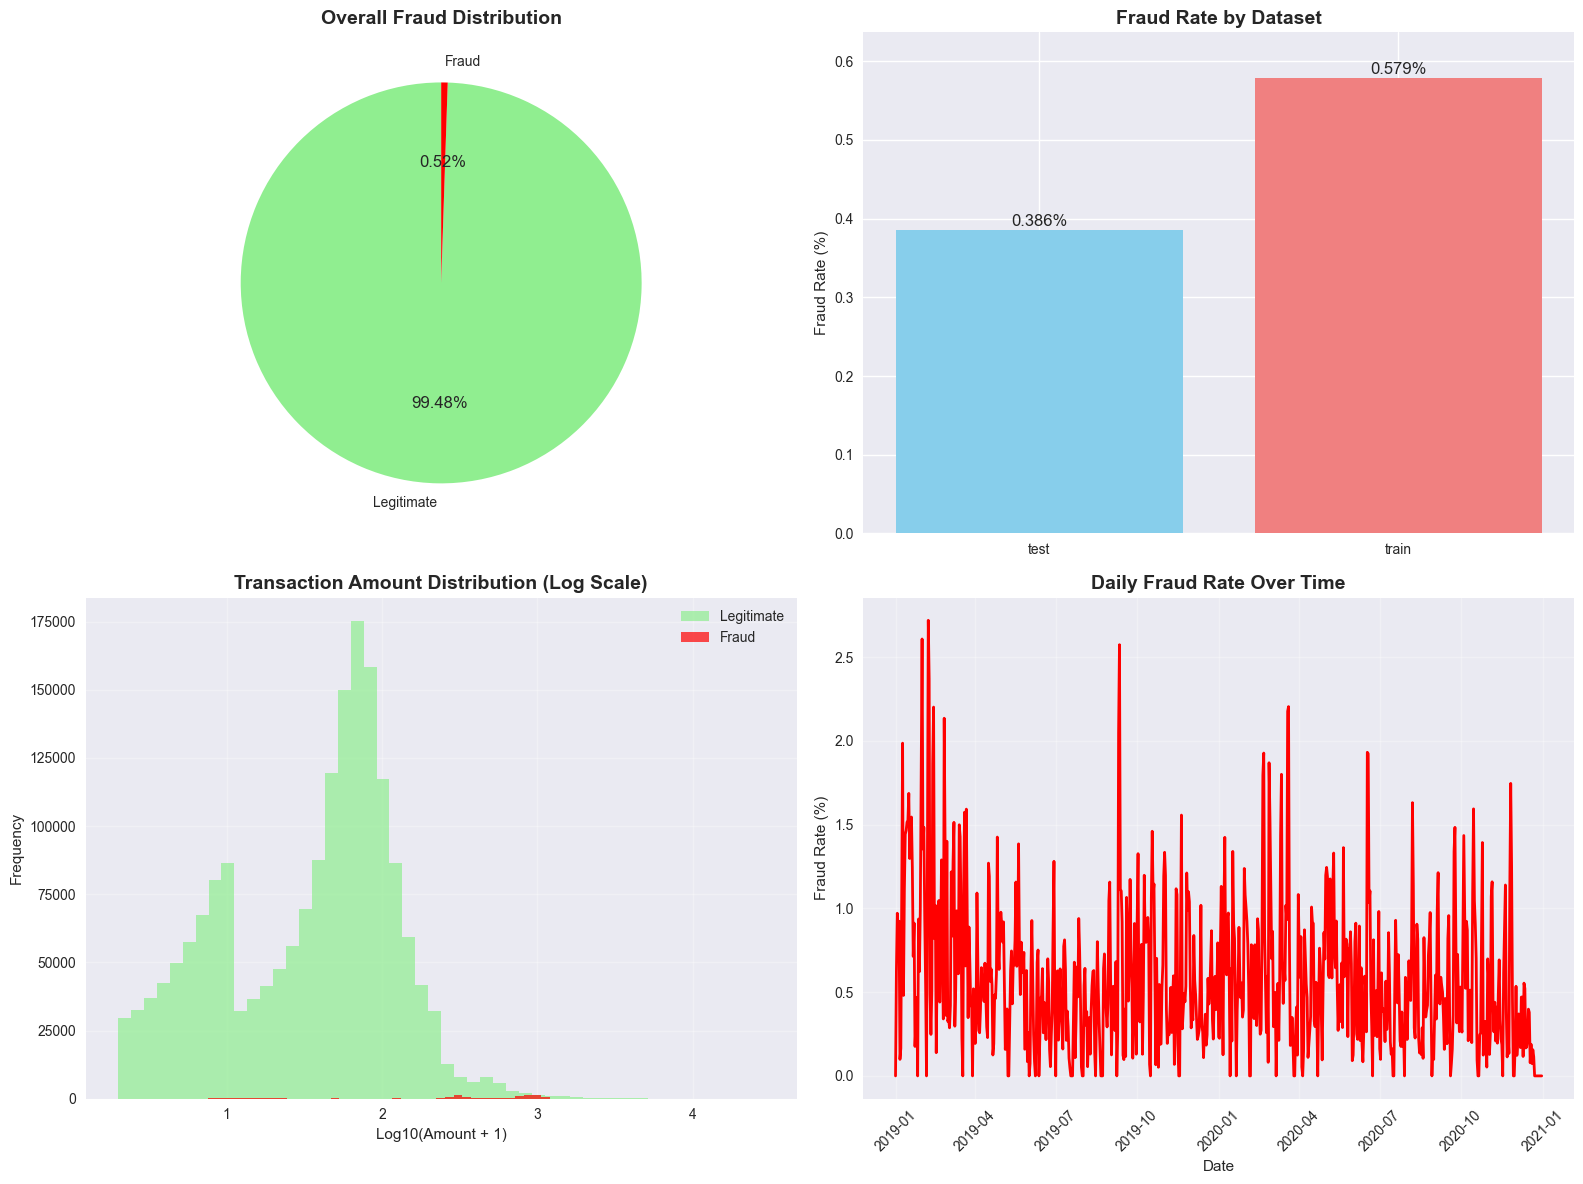


📈 STATISTICAL ANALYSIS
------------------------------
💰 AMOUNT STATISTICS
Fraudulent transactions:
  Mean: $530.66
  Median: $390.00
  Std: $391.03
  Max: $1376.04

Legitimate transactions:
  Mean: $67.65
  Median: $47.24
  Std: $153.55
  Max: $28948.90

🔬 T-TEST RESULTS
T-statistic: 291.3264
P-value: 0.00e+00
Significant difference: Yes (α=0.05)


In [6]:
if combined_df is not None:
    print("🚨 FRAUD ANALYSIS")
    print("=" * 30)
    
    # Basic fraud statistics
    fraud_stats = combined_df['is_fraud'].value_counts()
    fraud_rate = combined_df['is_fraud'].mean() * 100
    
    print(f"📊 FRAUD DISTRIBUTION")
    print("-" * 25)
    print(f"✅ Legitimate transactions: {fraud_stats[0]:,} ({100-fraud_rate:.2f}%)")
    print(f"🚨 Fraudulent transactions: {fraud_stats[1]:,} ({fraud_rate:.2f}%)")
    print(f"📈 Overall fraud rate: {fraud_rate:.4f}%")
    
    # Fraud by dataset
    print(f"\n📊 FRAUD BY DATASET")
    print("-" * 25)
    fraud_by_dataset = combined_df.groupby('dataset')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
    fraud_by_dataset.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
    fraud_by_dataset['Fraud_Rate_Percent'] = (fraud_by_dataset['Fraud_Rate'] * 100).round(2)
    print(fraud_by_dataset)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Fraud distribution pie chart
    axes[0,0].pie(fraud_stats.values, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%', 
                  colors=['lightgreen', 'red'], startangle=90)
    axes[0,0].set_title('Overall Fraud Distribution', fontsize=14, fontweight='bold')
    
    # 2. Fraud by dataset
    dataset_fraud = combined_df.groupby('dataset')['is_fraud'].mean() * 100
    bars = axes[0,1].bar(dataset_fraud.index, dataset_fraud.values, 
                        color=['skyblue', 'lightcoral'])
    axes[0,1].set_title('Fraud Rate by Dataset', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Fraud Rate (%)')
    axes[0,1].set_ylim(0, max(dataset_fraud.values) * 1.1)
    
    # Add value labels on bars
    for bar, value in zip(bars, dataset_fraud.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                      f'{value:.3f}%', ha='center', va='bottom')
    
    # 3. Transaction amount distribution by fraud status
    if 'amt' in combined_df.columns:
        fraud_amt = combined_df[combined_df['is_fraud'] == 1]['amt']
        legit_amt = combined_df[combined_df['is_fraud'] == 0]['amt']
        
        # Log scale for better visualization
        axes[1,0].hist(np.log10(legit_amt + 1), bins=50, alpha=0.7, label='Legitimate', color='lightgreen')
        axes[1,0].hist(np.log10(fraud_amt + 1), bins=50, alpha=0.7, label='Fraud', color='red')
        axes[1,0].set_title('Transaction Amount Distribution (Log Scale)', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Log10(Amount + 1)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Fraud rate over time (if temporal data available)
    if 'trans_date_trans_time' in combined_df.columns:
        try:
            # Convert to datetime if not already
            if not pd.api.types.is_datetime64_any_dtype(combined_df['trans_date_trans_time']):
                combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'])
            
            # Daily fraud rate
            daily_fraud = combined_df.groupby(combined_df['trans_date_trans_time'].dt.date)['is_fraud'].mean() * 100
            
            axes[1,1].plot(daily_fraud.index, daily_fraud.values, linewidth=2, color='red')
            axes[1,1].set_title('Daily Fraud Rate Over Time', fontsize=14, fontweight='bold')
            axes[1,1].set_xlabel('Date')
            axes[1,1].set_ylabel('Fraud Rate (%)')
            axes[1,1].tick_params(axis='x', rotation=45)
            axes[1,1].grid(True, alpha=0.3)
        except:
            axes[1,1].text(0.5, 0.5, 'Temporal analysis\nnot available', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Temporal Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📈 STATISTICAL ANALYSIS")
    print("-" * 30)
    
    if 'amt' in combined_df.columns:
        fraud_amt_stats = combined_df[combined_df['is_fraud'] == 1]['amt'].describe()
        legit_amt_stats = combined_df[combined_df['is_fraud'] == 0]['amt'].describe()
        
        print(f"💰 AMOUNT STATISTICS")
        print(f"Fraudulent transactions:")
        print(f"  Mean: ${fraud_amt_stats['mean']:.2f}")
        print(f"  Median: ${fraud_amt_stats['50%']:.2f}")
        print(f"  Std: ${fraud_amt_stats['std']:.2f}")
        print(f"  Max: ${fraud_amt_stats['max']:.2f}")
        
        print(f"\nLegitimate transactions:")
        print(f"  Mean: ${legit_amt_stats['mean']:.2f}")
        print(f"  Median: ${legit_amt_stats['50%']:.2f}")
        print(f"  Std: ${legit_amt_stats['std']:.2f}")
        print(f"  Max: ${legit_amt_stats['max']:.2f}")
        
        # Statistical test
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(fraud_amt, legit_amt)
        print(f"\n🔬 T-TEST RESULTS")
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.2e}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")


## 5. Temporal Analysis


⏰ TEMPORAL ANALYSIS
📅 TIME RANGE
--------------------
Start date: 2019-01-01 00:00:18
End date: 2020-12-31 23:59:34
Duration: 730 days

📊 DAILY STATISTICS
-------------------------
Average daily transactions: 2538
Average daily fraud rate: 0.581%
Highest daily fraud rate: 2.720%
Lowest daily fraud rate: 0.000%


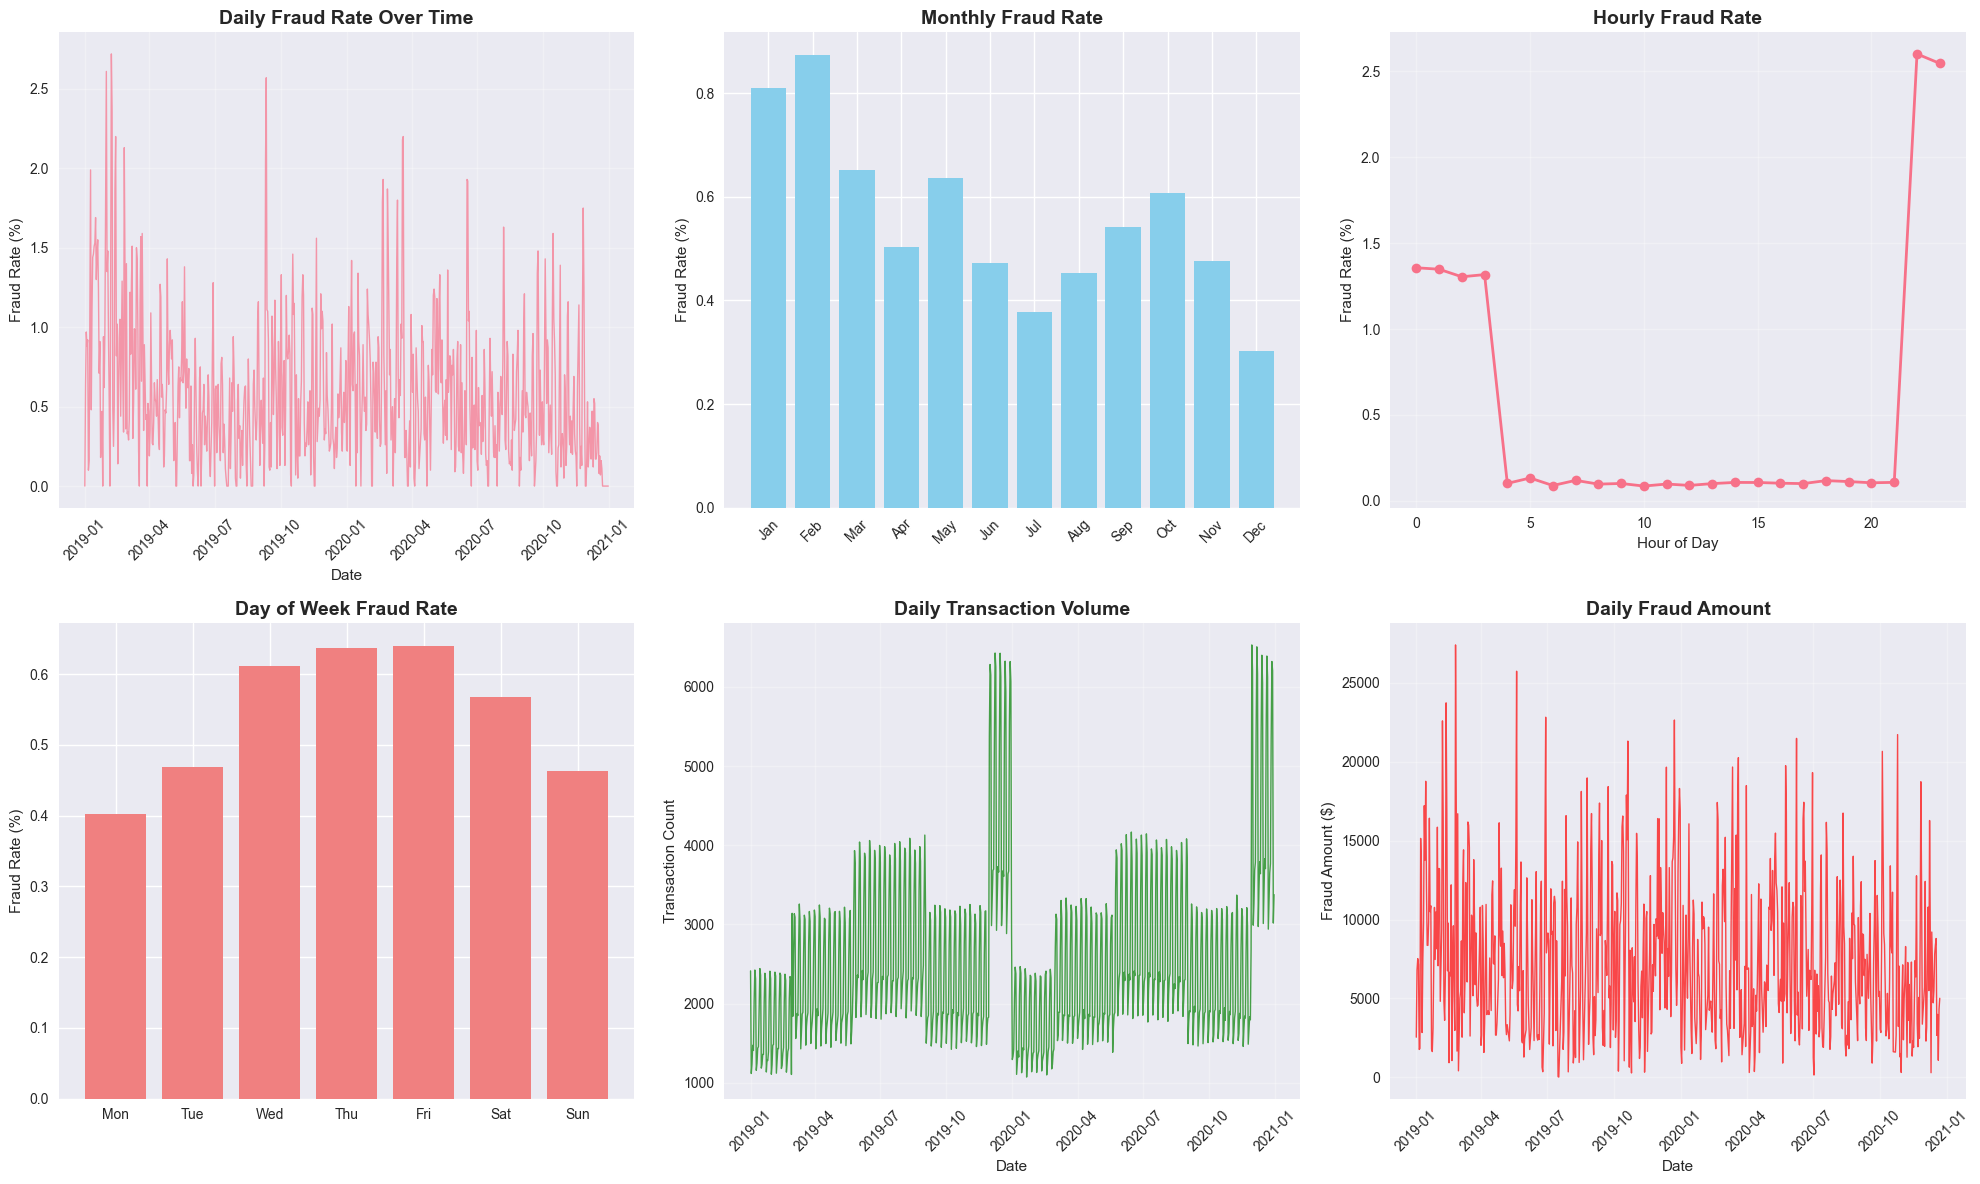


📈 TEMPORAL STATISTICS
------------------------------
📅 MONTHLY FRAUD RATES
     Total_Transactions  Fraud_Count  Fraud_Rate_Percent
Jan              104727          849                0.81
Feb               97657          853                0.87
Mar              143789          938                0.65
Apr              134970          678                0.50
May              146875          935                0.64
Jun              173869          821                0.47
Jul              172444          652                0.38
Aug              176118          797                0.45
Sep              140185          758                0.54
Oct              138106          838                0.61
Nov              143056          682                0.48
Dec              280598          850                0.30

🕐 HOURLY FRAUD RATES (Top 5)
      Total_Transactions  Fraud_Count  Fraud_Rate  Fraud_Rate_Percent
hour                                                                 
22           

In [7]:
if combined_df is not None and 'trans_date_trans_time' in combined_df.columns:
    print("⏰ TEMPORAL ANALYSIS")
    print("=" * 30)
    
    # Convert to datetime
    combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'])
    
    # Extract temporal features
    combined_df['year'] = combined_df['trans_date_trans_time'].dt.year
    combined_df['month'] = combined_df['trans_date_trans_time'].dt.month
    combined_df['day'] = combined_df['trans_date_trans_time'].dt.day
    combined_df['day_of_week'] = combined_df['trans_date_trans_time'].dt.dayofweek
    combined_df['hour'] = combined_df['trans_date_trans_time'].dt.hour
    combined_df['date'] = combined_df['trans_date_trans_time'].dt.date
    
    # Time range analysis
    print(f"📅 TIME RANGE")
    print("-" * 20)
    print(f"Start date: {combined_df['trans_date_trans_time'].min()}")
    print(f"End date: {combined_df['trans_date_trans_time'].max()}")
    print(f"Duration: {(combined_df['trans_date_trans_time'].max() - combined_df['trans_date_trans_time'].min()).days} days")
    
    # Daily analysis
    daily_stats = combined_df.groupby('date').agg({
        'is_fraud': ['count', 'sum', 'mean'],
        'amt': ['sum', 'mean']
    }).round(4)
    
    daily_stats.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate', 'Total_Amount', 'Avg_Amount']
    daily_stats['Fraud_Rate_Percent'] = (daily_stats['Fraud_Rate'] * 100).round(2)
    
    print(f"\n📊 DAILY STATISTICS")
    print("-" * 25)
    print(f"Average daily transactions: {daily_stats['Total_Transactions'].mean():.0f}")
    print(f"Average daily fraud rate: {daily_stats['Fraud_Rate_Percent'].mean():.3f}%")
    print(f"Highest daily fraud rate: {daily_stats['Fraud_Rate_Percent'].max():.3f}%")
    print(f"Lowest daily fraud rate: {daily_stats['Fraud_Rate_Percent'].min():.3f}%")
    
    # Create temporal visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Daily fraud rate over time
    axes[0,0].plot(daily_stats.index, daily_stats['Fraud_Rate_Percent'], linewidth=1, alpha=0.7)
    axes[0,0].set_title('Daily Fraud Rate Over Time', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Fraud Rate (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Monthly fraud rate
    monthly_fraud = combined_df.groupby('month')['is_fraud'].mean() * 100
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[0,1].bar(month_names, monthly_fraud.values, color='skyblue')
    axes[0,1].set_title('Monthly Fraud Rate', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Fraud Rate (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Hourly fraud rate
    hourly_fraud = combined_df.groupby('hour')['is_fraud'].mean() * 100
    axes[0,2].plot(hourly_fraud.index, hourly_fraud.values, marker='o', linewidth=2)
    axes[0,2].set_title('Hourly Fraud Rate', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Hour of Day')
    axes[0,2].set_ylabel('Fraud Rate (%)')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Day of week fraud rate
    dow_fraud = combined_df.groupby('day_of_week')['is_fraud'].mean() * 100
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1,0].bar(dow_names, dow_fraud.values, color='lightcoral')
    axes[1,0].set_title('Day of Week Fraud Rate', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Fraud Rate (%)')
    
    # 5. Daily transaction volume
    axes[1,1].plot(daily_stats.index, daily_stats['Total_Transactions'], linewidth=1, alpha=0.7, color='green')
    axes[1,1].set_title('Daily Transaction Volume', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Transaction Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Fraud amount over time
    daily_fraud_amt = combined_df[combined_df['is_fraud'] == 1].groupby('date')['amt'].sum()
    axes[1,2].plot(daily_fraud_amt.index, daily_fraud_amt.values, linewidth=1, alpha=0.7, color='red')
    axes[1,2].set_title('Daily Fraud Amount', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Date')
    axes[1,2].set_ylabel('Fraud Amount ($)')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📈 TEMPORAL STATISTICS")
    print("-" * 30)
    
    # Monthly analysis
    print(f"📅 MONTHLY FRAUD RATES")
    monthly_analysis = combined_df.groupby('month').agg({
        'is_fraud': ['count', 'sum', 'mean'],
        'amt': 'sum'
    }).round(4)
    monthly_analysis.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate', 'Total_Amount']
    monthly_analysis['Fraud_Rate_Percent'] = (monthly_analysis['Fraud_Rate'] * 100).round(2)
    monthly_analysis.index = [month_names[i-1] for i in monthly_analysis.index]
    print(monthly_analysis[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']])
    
    # Hourly analysis
    print(f"\n🕐 HOURLY FRAUD RATES (Top 5)")
    hourly_analysis = combined_df.groupby('hour')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
    hourly_analysis.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
    hourly_analysis['Fraud_Rate_Percent'] = (hourly_analysis['Fraud_Rate'] * 100).round(2)
    print(hourly_analysis.sort_values('Fraud_Rate_Percent', ascending=False).head())
    
    # Day of week analysis
    print(f"\n📅 DAY OF WEEK FRAUD RATES")
    dow_analysis = combined_df.groupby('day_of_week')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
    dow_analysis.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
    dow_analysis['Fraud_Rate_Percent'] = (dow_analysis['Fraud_Rate'] * 100).round(2)
    dow_analysis.index = dow_names
    print(dow_analysis[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']])
    
    # Correlation analysis
    print(f"\n🔗 TEMPORAL CORRELATIONS")
    print("-" * 30)
    
    # Create correlation matrix for temporal features
    temporal_features = ['year', 'month', 'day', 'day_of_week', 'hour', 'is_fraud']
    temporal_corr = combined_df[temporal_features].corr()
    
    print("Correlation with fraud:")
    fraud_corr = temporal_corr['is_fraud'].drop('is_fraud').sort_values(key=abs, ascending=False)
    for feature, corr in fraud_corr.items():
        print(f"  {feature}: {corr:.4f}")
    
else:
    print("❌ Temporal analysis not available - no date column found")


## 6. Merchant and Category Analysis


🏪 MERCHANT AND CATEGORY ANALYSIS
📊 CATEGORY ANALYSIS
-------------------------
Number of categories: 14

Top 10 categories by fraud rate:
               Total_Transactions  Fraud_Count  Fraud_Rate_Percent
category                                                          
shopping_net               139322         2219                1.59
misc_net                    90654         1182                1.30
grocery_pos                176191         2228                1.26
shopping_pos               166463         1056                0.63
gas_transport              188029          772                0.41
misc_pos                   114229          322                0.28
travel                      57956          156                0.27
grocery_net                 64878          175                0.27
entertainment              134118          292                0.22
personal_care              130085          290                0.22

Bottom 10 categories by fraud rate:
                Total

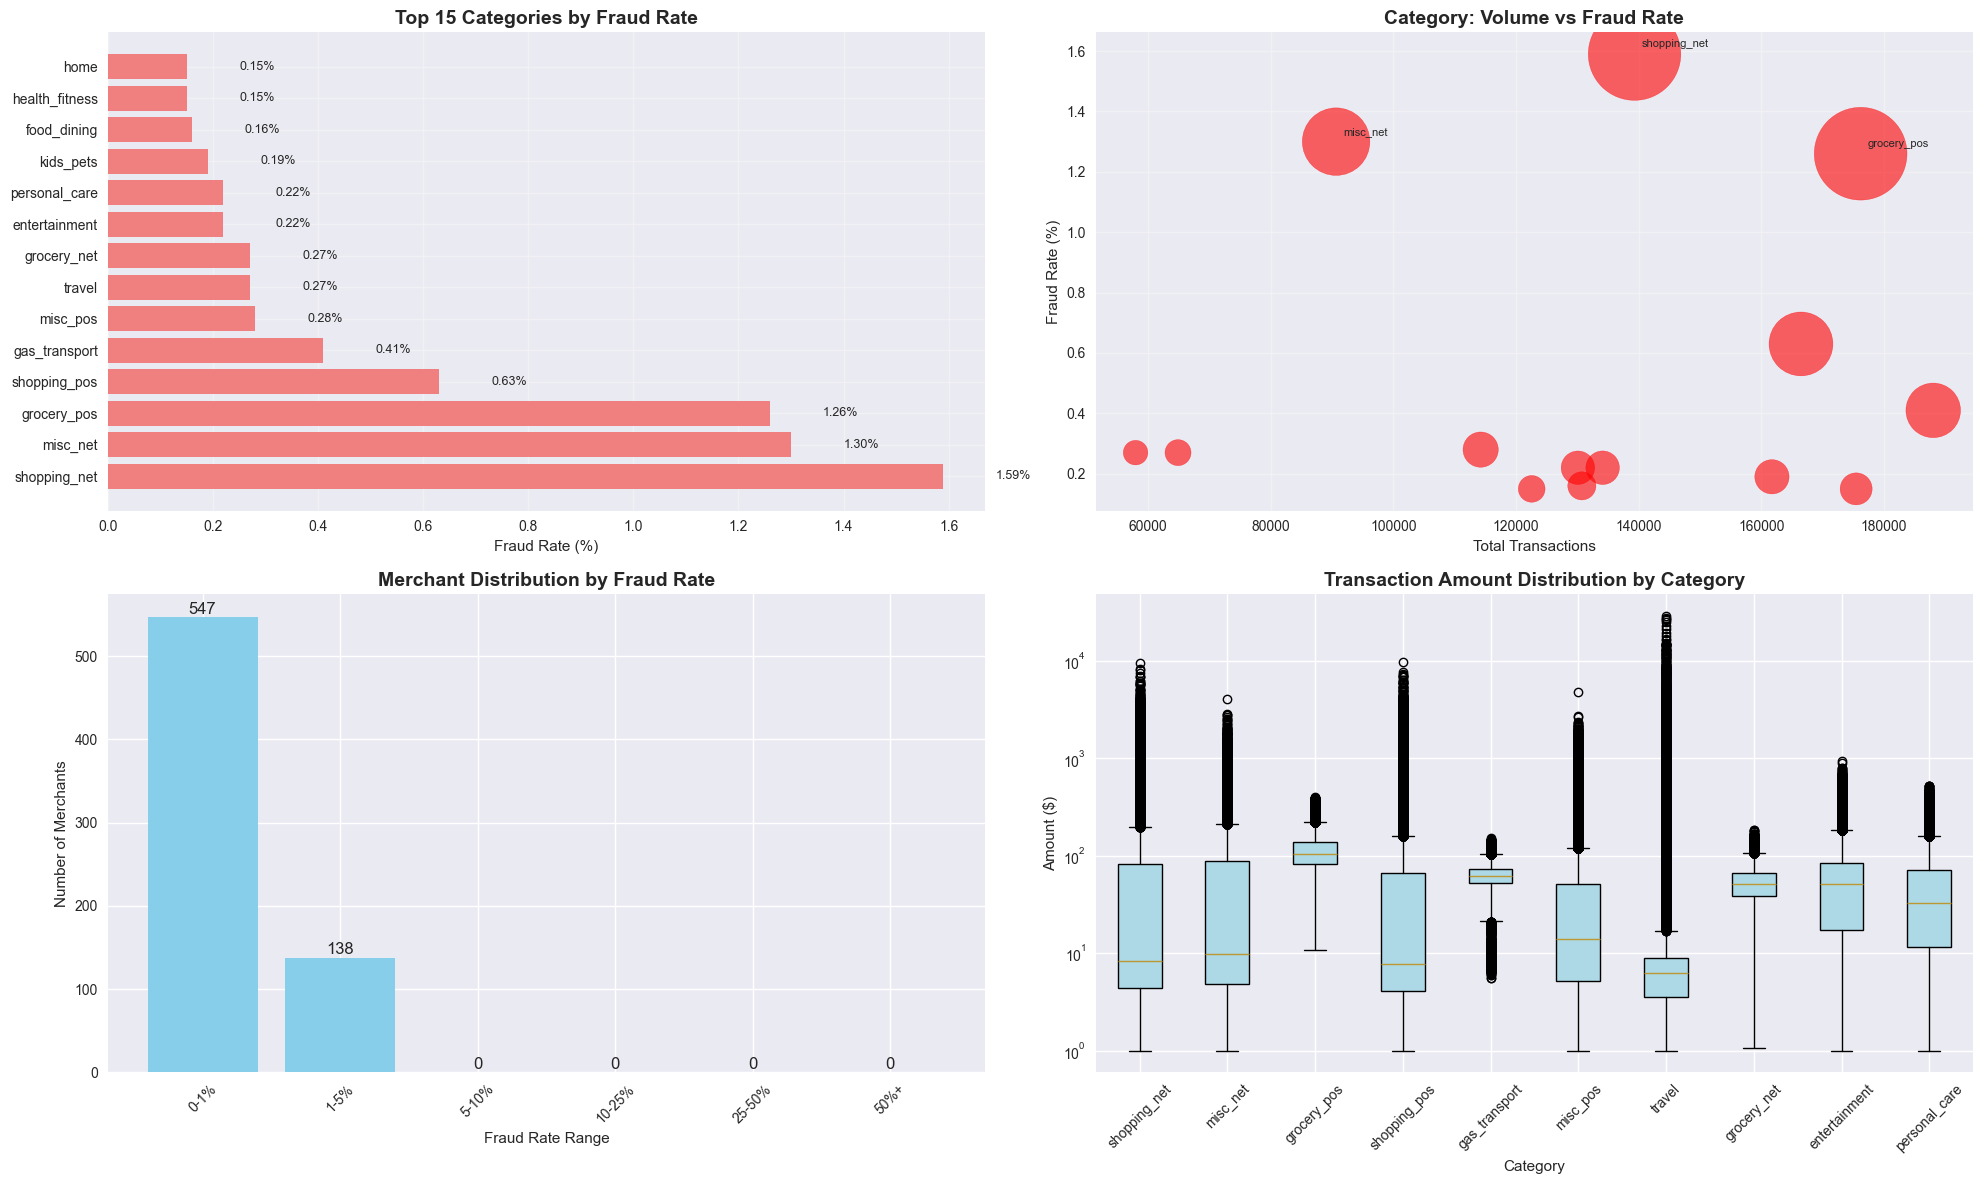


📈 STATISTICAL INSIGHTS
------------------------------
🚨 High-risk categories (fraud rate > 5%): 0
   These categories account for 0 transactions
   Total fraud in high-risk categories: 0

📊 Top 5 categories account for 77.3% of all fraud

💰 AMOUNT ANALYSIS BY CATEGORY
High-value categories (top 20% by avg amount):
              Avg_Amount  Fraud_Rate_Percent
category                                    
shopping_net     86.9420                1.59
grocery_pos     116.6401                1.26
travel          111.7712                0.27

🏪 Top 10 merchants account for 5.3% of all fraud
Merchants with fraud activity: 685 (98.8%)


In [8]:
if combined_df is not None:
    print("🏪 MERCHANT AND CATEGORY ANALYSIS")
    print("=" * 40)
    
    # Category analysis
    if 'category' in combined_df.columns:
        print(f"📊 CATEGORY ANALYSIS")
        print("-" * 25)
        
        category_stats = combined_df.groupby('category').agg({
            'is_fraud': ['count', 'sum', 'mean'],
            'amt': ['sum', 'mean']
        }).round(4)
        
        category_stats.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate', 'Total_Amount', 'Avg_Amount']
        category_stats['Fraud_Rate_Percent'] = (category_stats['Fraud_Rate'] * 100).round(2)
        category_stats = category_stats.sort_values('Fraud_Rate_Percent', ascending=False)
        
        print(f"Number of categories: {len(category_stats)}")
        print(f"\nTop 10 categories by fraud rate:")
        print(category_stats[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']].head(10))
        
        print(f"\nBottom 10 categories by fraud rate:")
        print(category_stats[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']].tail(10))
    
    # Merchant analysis
    if 'merchant' in combined_df.columns:
        print(f"\n🏪 MERCHANT ANALYSIS")
        print("-" * 25)
        
        merchant_stats = combined_df.groupby('merchant').agg({
            'is_fraud': ['count', 'sum', 'mean'],
            'amt': ['sum', 'mean']
        }).round(4)
        
        merchant_stats.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate', 'Total_Amount', 'Avg_Amount']
        merchant_stats['Fraud_Rate_Percent'] = (merchant_stats['Fraud_Rate'] * 100).round(2)
        merchant_stats = merchant_stats.sort_values('Fraud_Rate_Percent', ascending=False)
        
        print(f"Number of merchants: {len(merchant_stats)}")
        print(f"\nTop 10 merchants by fraud rate:")
        print(merchant_stats[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']].head(10))
        
        # High-risk merchants (fraud rate > 50%)
        high_risk_merchants = merchant_stats[merchant_stats['Fraud_Rate_Percent'] > 50]
        print(f"\n🚨 High-risk merchants (fraud rate > 50%): {len(high_risk_merchants)}")
        if len(high_risk_merchants) > 0:
            print(high_risk_merchants[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']])
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Category fraud rate (top 15)
    if 'category' in combined_df.columns:
        top_categories = category_stats.head(15)
        bars = axes[0,0].barh(range(len(top_categories)), top_categories['Fraud_Rate_Percent'], 
                             color='lightcoral')
        axes[0,0].set_yticks(range(len(top_categories)))
        axes[0,0].set_yticklabels(top_categories.index, fontsize=10)
        axes[0,0].set_title('Top 15 Categories by Fraud Rate', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('Fraud Rate (%)')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, top_categories['Fraud_Rate_Percent'])):
            axes[0,0].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                          f'{value:.2f}%', va='center', fontsize=9)
    
    # 2. Category transaction volume vs fraud rate
    if 'category' in combined_df.columns:
        scatter = axes[0,1].scatter(category_stats['Total_Transactions'], 
                                   category_stats['Fraud_Rate_Percent'],
                                   s=category_stats['Fraud_Count']*2, alpha=0.6, c='red')
        axes[0,1].set_title('Category: Volume vs Fraud Rate', fontsize=14, fontweight='bold')
        axes[0,1].set_xlabel('Total Transactions')
        axes[0,1].set_ylabel('Fraud Rate (%)')
        axes[0,1].grid(True, alpha=0.3)
        
        # Add category labels for high fraud rate categories
        high_fraud_cats = category_stats[category_stats['Fraud_Rate_Percent'] > category_stats['Fraud_Rate_Percent'].quantile(0.8)]
        for idx, row in high_fraud_cats.iterrows():
            axes[0,1].annotate(idx, (row['Total_Transactions'], row['Fraud_Rate_Percent']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Merchant fraud distribution
    if 'merchant' in combined_df.columns:
        # Bin merchants by fraud rate
        fraud_rate_bins = pd.cut(merchant_stats['Fraud_Rate_Percent'], 
                                bins=[0, 1, 5, 10, 25, 50, 100], 
                                labels=['0-1%', '1-5%', '5-10%', '10-25%', '25-50%', '50%+'])
        bin_counts = fraud_rate_bins.value_counts().sort_index()
        
        axes[1,0].bar(bin_counts.index, bin_counts.values, color='skyblue')
        axes[1,0].set_title('Merchant Distribution by Fraud Rate', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Fraud Rate Range')
        axes[1,0].set_ylabel('Number of Merchants')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for bar, count in zip(axes[1,0].patches, bin_counts.values):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                          f'{count}', ha='center', va='bottom')
    
    # 4. Amount distribution by category (top 10 categories)
    if 'category' in combined_df.columns and 'amt' in combined_df.columns:
        top_10_cats = category_stats.head(10).index
        cat_amounts = []
        cat_labels = []
        
        for cat in top_10_cats:
            cat_data = combined_df[combined_df['category'] == cat]['amt']
            cat_amounts.append(cat_data)
            cat_labels.append(cat)
        
        box_plot = axes[1,1].boxplot(cat_amounts, labels=cat_labels, patch_artist=True)
        axes[1,1].set_title('Transaction Amount Distribution by Category', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Category')
        axes[1,1].set_ylabel('Amount ($)')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].set_yscale('log')
        
        # Color boxes based on fraud rate
        for patch, cat in zip(box_plot['boxes'], cat_labels):
            fraud_rate = category_stats.loc[cat, 'Fraud_Rate_Percent']
            if fraud_rate > 10:
                patch.set_facecolor('red')
            elif fraud_rate > 5:
                patch.set_facecolor('orange')
            else:
                patch.set_facecolor('lightblue')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical insights
    print(f"\n📈 STATISTICAL INSIGHTS")
    print("-" * 30)
    
    if 'category' in combined_df.columns:
        # Category risk analysis
        high_risk_cats = category_stats[category_stats['Fraud_Rate_Percent'] > 5]
        print(f"🚨 High-risk categories (fraud rate > 5%): {len(high_risk_cats)}")
        print(f"   These categories account for {high_risk_cats['Total_Transactions'].sum():,} transactions")
        print(f"   Total fraud in high-risk categories: {high_risk_cats['Fraud_Count'].sum():,}")
        
        # Category concentration
        top_5_cats = category_stats.head(5)
        top_5_fraud_share = top_5_cats['Fraud_Count'].sum() / category_stats['Fraud_Count'].sum() * 100
        print(f"\n📊 Top 5 categories account for {top_5_fraud_share:.1f}% of all fraud")
        
        # Amount analysis by category
        if 'amt' in combined_df.columns:
            print(f"\n💰 AMOUNT ANALYSIS BY CATEGORY")
            high_value_cats = category_stats[category_stats['Avg_Amount'] > category_stats['Avg_Amount'].quantile(0.8)]
            print(f"High-value categories (top 20% by avg amount):")
            print(high_value_cats[['Avg_Amount', 'Fraud_Rate_Percent']].head())
    
    if 'merchant' in combined_df.columns:
        # Merchant concentration
        top_10_merchants = merchant_stats.head(10)
        top_10_fraud_share = top_10_merchants['Fraud_Count'].sum() / merchant_stats['Fraud_Count'].sum() * 100
        print(f"\n🏪 Top 10 merchants account for {top_10_fraud_share:.1f}% of all fraud")
        
        # Merchant diversity
        total_merchants = len(merchant_stats)
        merchants_with_fraud = len(merchant_stats[merchant_stats['Fraud_Count'] > 0])
        print(f"Merchants with fraud activity: {merchants_with_fraud:,} ({merchants_with_fraud/total_merchants*100:.1f}%)")


## 7. Geographic Analysis


🌍 GEOGRAPHIC ANALYSIS
📍 Available geographic columns: ['lat', 'long', 'merch_lat', 'merch_long', 'state', 'city', 'zip']

��️ STATE ANALYSIS
--------------------
Number of states: 51

Top 10 states by fraud rate:
       Total_Transactions  Fraud_Count  Fraud_Rate_Percent
state                                                     
DE                      9            9              100.00
RI                    745           15                2.01
AK                   2963           50                1.69
OR                  26408          197                0.75
NH                  11727           79                0.67
VA                  41756          273                0.65
TN                  24913          159                0.64
NE                  34425          216                0.63
MN                  45433          280                0.62
NY                 119419          730                0.61

Bottom 10 states by fraud rate:
       Total_Transactions  Fraud_Count  Fraud_

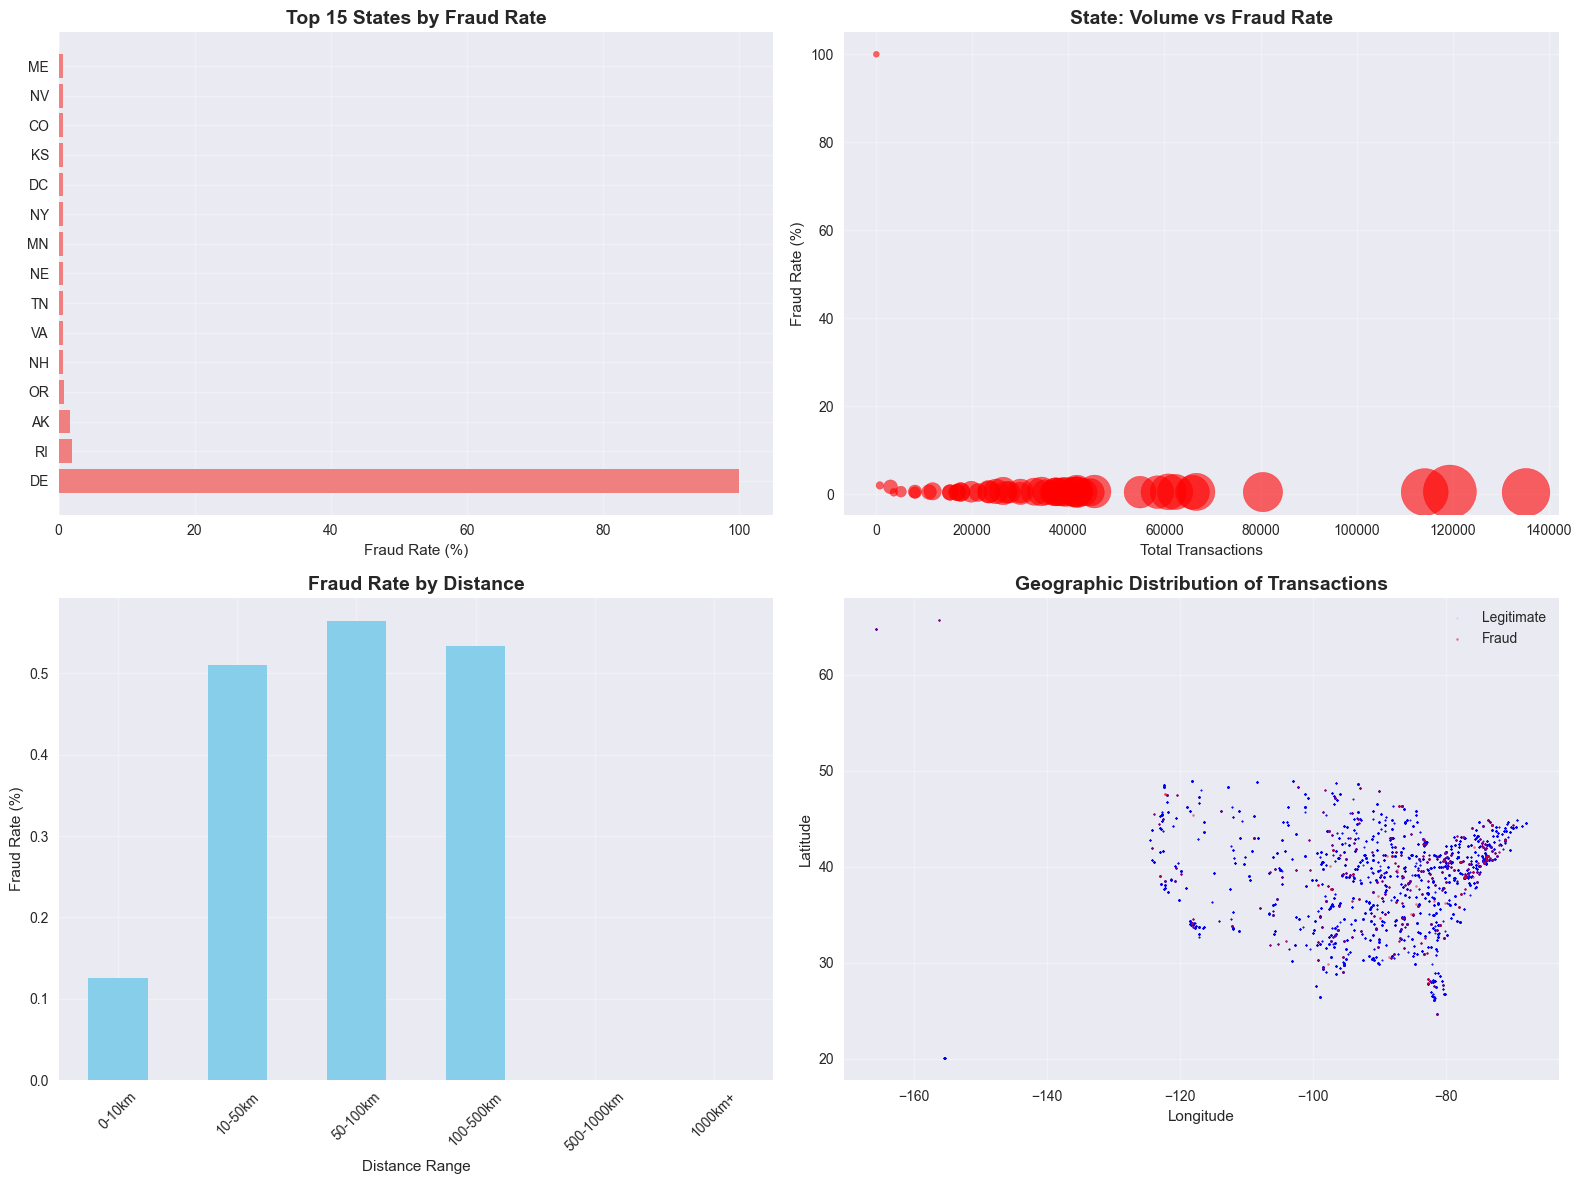


📈 GEOGRAPHIC INSIGHTS
------------------------------
�� High-risk states (fraud rate > 1%): 3
   These states account for 3,717 transactions
   Total fraud in high-risk states: 74

📊 Top 5 states account for 3.6% of all fraud

📏 DISTANCE INSIGHTS
Average distance for fraud: 76.76 km
Average distance for legitimate: 76.13 km
Distance difference: 0.63 km


In [12]:
if combined_df is not None:
    print("🌍 GEOGRAPHIC ANALYSIS")
    print("=" * 30)
    
    # Check for geographic columns
    geo_columns = ['lat', 'long', 'merch_lat', 'merch_long', 'state', 'city', 'zip']
    available_geo = [col for col in geo_columns if col in combined_df.columns]
    
    if available_geo:
        print(f"📍 Available geographic columns: {available_geo}")
        
        # State analysis
        if 'state' in combined_df.columns:
            print(f"\n��️ STATE ANALYSIS")
            print("-" * 20)
            
            state_stats = combined_df.groupby('state').agg({
                'is_fraud': ['count', 'sum', 'mean'],
                'amt': ['sum', 'mean']
            }).round(4)
            
            state_stats.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate', 'Total_Amount', 'Avg_Amount']
            state_stats['Fraud_Rate_Percent'] = (state_stats['Fraud_Rate'] * 100).round(2)
            state_stats = state_stats.sort_values('Fraud_Rate_Percent', ascending=False)
            
            print(f"Number of states: {len(state_stats)}")
            print(f"\nTop 10 states by fraud rate:")
            print(state_stats[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']].head(10))
            
            print(f"\nBottom 10 states by fraud rate:")
            print(state_stats[['Total_Transactions', 'Fraud_Count', 'Fraud_Rate_Percent']].tail(10))
        
        # Distance analysis (if lat/long available)
        if all(col in combined_df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
            print(f"\n📏 DISTANCE ANALYSIS")
            print("-" * 25)
            
            # Calculate distance between customer and merchant
            def calculate_distance(lat1, lon1, lat2, lon2):
                # Haversine formula
                R = 6371  # Earth's radius in kilometers
                dlat = np.radians(lat2 - lat1)
                dlon = np.radians(lon2 - lon1)
                a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))
                return R * c
            
            # Sample for performance (use 10% of data)
            sample_size = min(100000, len(combined_df))
            sample_df = combined_df.sample(n=sample_size, random_state=42)
            
            sample_df['distance_km'] = calculate_distance(
                sample_df['lat'], sample_df['long'],
                sample_df['merch_lat'], sample_df['merch_long']
            )
            
            # Distance analysis
            distance_stats = sample_df.groupby('is_fraud')['distance_km'].describe()
            print("Distance statistics by fraud status:")
            print(distance_stats)
            
            # Distance bins
            sample_df['distance_bin'] = pd.cut(sample_df['distance_km'], 
                                             bins=[0, 10, 50, 100, 500, 1000, float('inf')],
                                             labels=['0-10km', '10-50km', '50-100km', '100-500km', '500-1000km', '1000km+'])
            
            distance_fraud = sample_df.groupby('distance_bin')['is_fraud'].mean() * 100
            print(f"\nFraud rate by distance:")
            print(distance_fraud)
        
        # Create geographic visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. State fraud rate (top 15)
        if 'state' in combined_df.columns:
            top_states = state_stats.head(15)
            bars = axes[0,0].barh(range(len(top_states)), top_states['Fraud_Rate_Percent'], 
                                 color='lightcoral')
            axes[0,0].set_yticks(range(len(top_states)))
            axes[0,0].set_yticklabels(top_states.index, fontsize=10)
            axes[0,0].set_title('Top 15 States by Fraud Rate', fontsize=14, fontweight='bold')
            axes[0,0].set_xlabel('Fraud Rate (%)')
            axes[0,0].grid(True, alpha=0.3)
        
        # 2. State transaction volume vs fraud rate
        if 'state' in combined_df.columns:
            scatter = axes[0,1].scatter(state_stats['Total_Transactions'], 
                                       state_stats['Fraud_Rate_Percent'],
                                       s=state_stats['Fraud_Count']*2, alpha=0.6, c='red')
            axes[0,1].set_title('State: Volume vs Fraud Rate', fontsize=14, fontweight='bold')
            axes[0,1].set_xlabel('Total Transactions')
            axes[0,1].set_ylabel('Fraud Rate (%)')
            axes[0,1].grid(True, alpha=0.3)
        
        # 3. Distance vs fraud rate
        if all(col in combined_df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
            distance_fraud.plot(kind='bar', ax=axes[1,0], color='skyblue')
            axes[1,0].set_title('Fraud Rate by Distance', fontsize=14, fontweight='bold')
            axes[1,0].set_xlabel('Distance Range')
            axes[1,0].set_ylabel('Fraud Rate (%)')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].grid(True, alpha=0.3)
        
        # 4. Geographic distribution of fraud
        if all(col in combined_df.columns for col in ['lat', 'long']):
            # Sample for performance - use different variable name to avoid conflict
            geo_sample_size = min(50000, len(combined_df))
            geo_sample_df = combined_df.sample(n=geo_sample_size, random_state=42)
            
            fraud_sample = geo_sample_df[geo_sample_df['is_fraud'] == 1]
            legit_sample = geo_sample_df[geo_sample_df['is_fraud'] == 0]
            
            axes[1,1].scatter(legit_sample['long'], legit_sample['lat'], 
                             alpha=0.1, s=1, c='blue', label='Legitimate')
            axes[1,1].scatter(fraud_sample['long'], fraud_sample['lat'], 
                             alpha=0.5, s=2, c='red', label='Fraud')
            axes[1,1].set_title('Geographic Distribution of Transactions', fontsize=14, fontweight='bold')
            axes[1,1].set_xlabel('Longitude')
            axes[1,1].set_ylabel('Latitude')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Geographic insights
        print(f"\n📈 GEOGRAPHIC INSIGHTS")
        print("-" * 30)
        
        if 'state' in combined_df.columns:
            # State risk analysis
            high_risk_states = state_stats[state_stats['Fraud_Rate_Percent'] > 1]
            print(f"�� High-risk states (fraud rate > 1%): {len(high_risk_states)}")
            print(f"   These states account for {high_risk_states['Total_Transactions'].sum():,} transactions")
            print(f"   Total fraud in high-risk states: {high_risk_states['Fraud_Count'].sum():,}")
            
            # State concentration
            top_5_states = state_stats.head(5)
            top_5_fraud_share = top_5_states['Fraud_Count'].sum() / state_stats['Fraud_Count'].sum() * 100
            print(f"\n📊 Top 5 states account for {top_5_fraud_share:.1f}% of all fraud")
        
        if all(col in combined_df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
            # Distance insights - use the sample_df with distance_km from earlier
            avg_distance_fraud = sample_df[sample_df['is_fraud'] == 1]['distance_km'].mean()
            avg_distance_legit = sample_df[sample_df['is_fraud'] == 0]['distance_km'].mean()
            print(f"\n📏 DISTANCE INSIGHTS")
            print(f"Average distance for fraud: {avg_distance_fraud:.2f} km")
            print(f"Average distance for legitimate: {avg_distance_legit:.2f} km")
            print(f"Distance difference: {avg_distance_fraud - avg_distance_legit:.2f} km")
    
    else:
        print("❌ No geographic columns found for analysis")
        print("Available columns:", list(combined_df.columns))

## 8. Feature Engineering and Advanced Analysis


🔧 FEATURE ENGINEERING AND ADVANCED ANALYSIS
🛠️ CREATING ENGINEERED FEATURES
-----------------------------------
✅ Amount-based features created
✅ Temporal features created
✅ Geographic features created (sample)
✅ Merchant features created
✅ Category features created

🔗 CORRELATION ANALYSIS
------------------------------
Top 10 features correlated with fraud:
  amount_sqrt: 0.2111
  amt: 0.2093
  amount_log: 0.1143
  is_night: 0.0887
  amount_rank: 0.0834
  is_business_hours: -0.0429
  month: -0.0164
  unix_time: -0.0133
  hour: 0.0132
  merchant_frequency: 0.0067


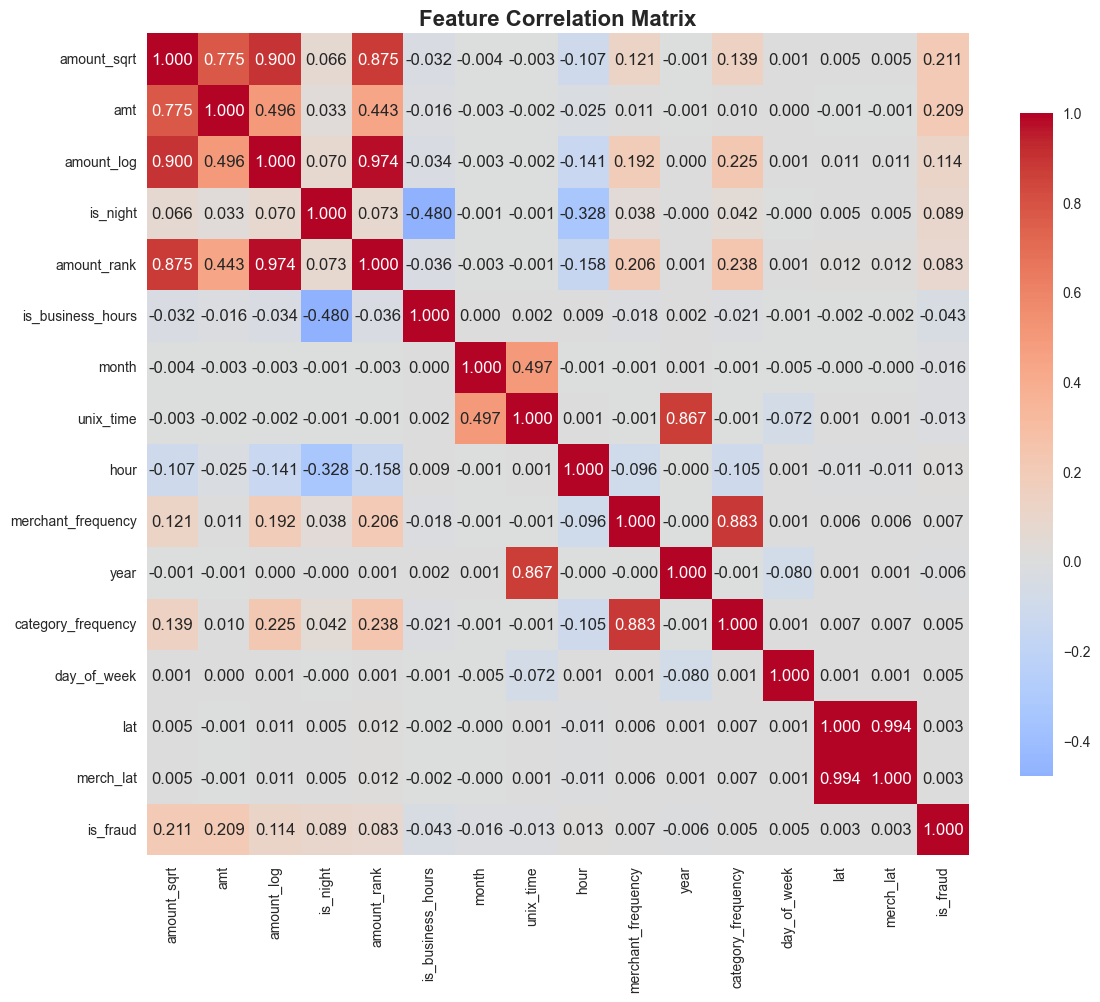


📊 FEATURE IMPORTANCE ANALYSIS
-----------------------------------
Statistical significance tests:
  category (Chi-square): p-value = 0.00e+00
  merchant (Chi-square): p-value = 0.00e+00
  state (Chi-square): p-value = 0.00e+00
  gender (Chi-square): p-value = 1.97e-15
  amt (T-test): p-value = 0.00e+00
  hour (T-test): p-value = 3.96e-72
  day_of_week (T-test): p-value = 5.35e-10
  month (T-test): p-value = 1.32e-110

📈 SUMMARY STATISTICS
-------------------------
Total features: 41
Numeric features: 26
Categorical features: 13
Engineered features: 0

Data quality:
  Missing values: 0
  Duplicate rows: 0
  Data completeness: 100.00%

✅ Feature engineering completed!
Dataset shape after feature engineering: (1852394, 41)


In [10]:
if combined_df is not None:
    print("🔧 FEATURE ENGINEERING AND ADVANCED ANALYSIS")
    print("=" * 50)
    
    # Create engineered features
    print("🛠️ CREATING ENGINEERED FEATURES")
    print("-" * 35)
    
    # Amount-based features
    if 'amt' in combined_df.columns:
        combined_df['amount_log'] = np.log10(combined_df['amt'] + 1)
        combined_df['amount_sqrt'] = np.sqrt(combined_df['amt'])
        combined_df['amount_rank'] = combined_df['amt'].rank(pct=True)
        
        # Amount bins
        combined_df['amount_bin'] = pd.cut(combined_df['amt'], 
                                         bins=[0, 10, 50, 100, 500, 1000, float('inf')],
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme'])
        
        print("✅ Amount-based features created")
    
    # Temporal features (if not already created)
    if 'trans_date_trans_time' in combined_df.columns:
        if 'hour' not in combined_df.columns:
            combined_df['hour'] = combined_df['trans_date_trans_time'].dt.hour
        if 'day_of_week' not in combined_df.columns:
            combined_df['day_of_week'] = combined_df['trans_date_trans_time'].dt.dayofweek
        if 'month' not in combined_df.columns:
            combined_df['month'] = combined_df['trans_date_trans_time'].dt.month
        
        # Time-based features
        combined_df['is_weekend'] = combined_df['day_of_week'].isin([5, 6]).astype(int)
        combined_df['is_night'] = combined_df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
        combined_df['is_business_hours'] = combined_df['hour'].isin(range(9, 17)).astype(int)
        
        print("✅ Temporal features created")
    
    # Geographic features
    if all(col in combined_df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
        # Distance calculation (sample for performance)
        sample_size = min(50000, len(combined_df))
        sample_df = combined_df.sample(n=sample_size, random_state=42)
        
        def calculate_distance(lat1, lon1, lat2, lon2):
            R = 6371
            dlat = np.radians(lat2 - lat1)
            dlon = np.radians(lon2 - lon1)
            a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            return R * c
        
        sample_df['distance_km'] = calculate_distance(
            sample_df['lat'], sample_df['long'],
            sample_df['merch_lat'], sample_df['merch_long']
        )
        
        # Distance bins
        sample_df['distance_bin'] = pd.cut(sample_df['distance_km'], 
                                         bins=[0, 10, 50, 100, 500, 1000, float('inf')],
                                         labels=['Local', 'Nearby', 'Regional', 'Distant', 'Very Distant', 'International'])
        
        print("✅ Geographic features created (sample)")
    
    # Merchant features
    if 'merchant' in combined_df.columns:
        # Merchant frequency
        merchant_counts = combined_df['merchant'].value_counts()
        combined_df['merchant_frequency'] = combined_df['merchant'].map(merchant_counts)
        combined_df['merchant_rare'] = (combined_df['merchant_frequency'] < 10).astype(int)
        
        print("✅ Merchant features created")
    
    # Category features
    if 'category' in combined_df.columns:
        # Category frequency
        category_counts = combined_df['category'].value_counts()
        combined_df['category_frequency'] = combined_df['category'].map(category_counts)
        combined_df['category_rare'] = (combined_df['category_frequency'] < 100).astype(int)
        
        print("✅ Category features created")
    
    # Correlation analysis
    print(f"\n🔗 CORRELATION ANALYSIS")
    print("-" * 30)
    
    # Select numeric features for correlation
    numeric_features = combined_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'is_fraud' in numeric_features:
        numeric_features.remove('is_fraud')
    
    # Calculate correlations with fraud
    fraud_correlations = []
    for feature in numeric_features:
        if feature in combined_df.columns:
            corr = combined_df[feature].corr(combined_df['is_fraud'])
            if not np.isnan(corr):
                fraud_correlations.append((feature, corr))
    
    fraud_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top 10 features correlated with fraud:")
    for feature, corr in fraud_correlations[:10]:
        print(f"  {feature}: {corr:.4f}")
    
    # Create correlation heatmap
    if len(fraud_correlations) > 0:
        # Select top 15 features for visualization
        top_features = [feat for feat, _ in fraud_correlations[:15]] + ['is_fraud']
        corr_matrix = combined_df[top_features].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Feature importance analysis
    print(f"\n📊 FEATURE IMPORTANCE ANALYSIS")
    print("-" * 35)
    
    # Statistical tests for feature importance
    from scipy.stats import chi2_contingency, ttest_ind
    
    categorical_features = ['category', 'merchant', 'state', 'gender']
    numeric_features_for_test = ['amt', 'hour', 'day_of_week', 'month']
    
    print("Statistical significance tests:")
    
    # Chi-square tests for categorical features
    for feature in categorical_features:
        if feature in combined_df.columns:
            try:
                contingency_table = pd.crosstab(combined_df[feature], combined_df['is_fraud'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                print(f"  {feature} (Chi-square): p-value = {p_value:.2e}")
            except:
                print(f"  {feature} (Chi-square): Test failed")
    
    # T-tests for numeric features
    for feature in numeric_features_for_test:
        if feature in combined_df.columns:
            try:
                fraud_values = combined_df[combined_df['is_fraud'] == 1][feature]
                legit_values = combined_df[combined_df['is_fraud'] == 0][feature]
                t_stat, p_value = ttest_ind(fraud_values, legit_values)
                print(f"  {feature} (T-test): p-value = {p_value:.2e}")
            except:
                print(f"  {feature} (T-test): Test failed")
    
    # Summary statistics
    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 25)
    
    total_features = len(combined_df.columns)
    numeric_features_count = len(combined_df.select_dtypes(include=[np.number]).columns)
    categorical_features_count = len(combined_df.select_dtypes(include=['object']).columns)
    
    print(f"Total features: {total_features}")
    print(f"Numeric features: {numeric_features_count}")
    print(f"Categorical features: {categorical_features_count}")
    print(f"Engineered features: {len([col for col in combined_df.columns if col not in train_df.columns if 'train_df' in locals()])}")
    
    # Data quality summary
    missing_values = combined_df.isnull().sum().sum()
    duplicate_rows = combined_df.duplicated().sum()
    
    print(f"\nData quality:")
    print(f"  Missing values: {missing_values:,}")
    print(f"  Duplicate rows: {duplicate_rows:,}")
    print(f"  Data completeness: {((len(combined_df) - missing_values) / len(combined_df) * 100):.2f}%")
    
    print(f"\n✅ Feature engineering completed!")
    print(f"Dataset shape after feature engineering: {combined_df.shape}")


## 9. Key Findings and Business Insights


In [11]:
if combined_df is not None:
    print("🎯 KEY FINDINGS AND BUSINESS INSIGHTS")
    print("=" * 45)
    
    # Overall fraud statistics
    total_transactions = len(combined_df)
    fraud_count = combined_df['is_fraud'].sum()
    fraud_rate = (fraud_count / total_transactions) * 100
    
    print(f"📊 OVERALL FRAUD STATISTICS")
    print("-" * 30)
    print(f"Total transactions analyzed: {total_transactions:,}")
    print(f"Fraudulent transactions: {fraud_count:,}")
    print(f"Overall fraud rate: {fraud_rate:.4f}%")
    print(f"Legitimate transactions: {total_transactions - fraud_count:,} ({100-fraud_rate:.2f}%)")
    
    # Key insights
    print(f"\n🔍 KEY INSIGHTS")
    print("-" * 20)
    
    # 1. Temporal patterns
    if 'hour' in combined_df.columns:
        hourly_fraud = combined_df.groupby('hour')['is_fraud'].mean() * 100
        highest_fraud_hour = hourly_fraud.idxmax()
        lowest_fraud_hour = hourly_fraud.idxmin()
        print(f"⏰ TEMPORAL PATTERNS:")
        print(f"   • Highest fraud rate: {highest_fraud_hour}:00 ({hourly_fraud[highest_fraud_hour]:.3f}%)")
        print(f"   • Lowest fraud rate: {lowest_fraud_hour}:00 ({hourly_fraud[lowest_fraud_hour]:.3f}%)")
    
    if 'day_of_week' in combined_df.columns:
        dow_fraud = combined_df.groupby('day_of_week')['is_fraud'].mean() * 100
        dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        highest_fraud_dow = dow_fraud.idxmax()
        print(f"   • Highest fraud day: {dow_names[highest_fraud_dow]} ({dow_fraud[highest_fraud_dow]:.3f}%)")
    
    # 2. Amount patterns
    if 'amt' in combined_df.columns:
        fraud_amt_stats = combined_df[combined_df['is_fraud'] == 1]['amt'].describe()
        legit_amt_stats = combined_df[combined_df['is_fraud'] == 0]['amt'].describe()
        
        print(f"\n💰 AMOUNT PATTERNS:")
        print(f"   • Average fraud amount: ${fraud_amt_stats['mean']:.2f}")
        print(f"   • Average legitimate amount: ${legit_amt_stats['mean']:.2f}")
        print(f"   • Amount difference: ${fraud_amt_stats['mean'] - legit_amt_stats['mean']:.2f}")
        
        # High-value transactions
        high_value_threshold = combined_df['amt'].quantile(0.95)
        high_value_fraud_rate = combined_df[combined_df['amt'] > high_value_threshold]['is_fraud'].mean() * 100
        print(f"   • High-value fraud rate (>${high_value_threshold:.0f}): {high_value_fraud_rate:.3f}%")
    
    # 3. Category patterns
    if 'category' in combined_df.columns:
        category_fraud = combined_df.groupby('category')['is_fraud'].mean() * 100
        top_risk_category = category_fraud.idxmax()
        top_risk_rate = category_fraud.max()
        
        print(f"\n🏪 CATEGORY PATTERNS:")
        print(f"   • Highest risk category: {top_risk_category} ({top_risk_rate:.3f}%)")
        
        # High-risk categories
        high_risk_cats = category_fraud[category_fraud > 5]
        print(f"   • High-risk categories (>5% fraud): {len(high_risk_cats)}")
        
        # Category concentration
        top_5_cats = category_fraud.nlargest(5)
        top_5_fraud_share = top_5_cats.sum() / category_fraud.sum() * 100
        print(f"   • Top 5 categories account for {top_5_fraud_share:.1f}% of fraud rate")
    
    # 4. Geographic patterns
    if 'state' in combined_df.columns:
        state_fraud = combined_df.groupby('state')['is_fraud'].mean() * 100
        top_risk_state = state_fraud.idxmax()
        top_risk_state_rate = state_fraud.max()
        
        print(f"\n🌍 GEOGRAPHIC PATTERNS:")
        print(f"   • Highest risk state: {top_risk_state} ({top_risk_state_rate:.3f}%)")
        
        # High-risk states
        high_risk_states = state_fraud[state_fraud > 1]
        print(f"   • High-risk states (>1% fraud): {len(high_risk_states)}")
    
    # 5. Merchant patterns
    if 'merchant' in combined_df.columns:
        merchant_fraud = combined_df.groupby('merchant')['is_fraud'].mean() * 100
        high_risk_merchants = merchant_fraud[merchant_fraud > 50]
        
        print(f"\n🏪 MERCHANT PATTERNS:")
        print(f"   • Total merchants: {len(merchant_fraud):,}")
        print(f"   • High-risk merchants (>50% fraud): {len(high_risk_merchants)}")
        print(f"   • Merchants with fraud: {len(merchant_fraud[merchant_fraud > 0]):,}")
    
    # Business recommendations
    print(f"\n💡 BUSINESS RECOMMENDATIONS")
    print("-" * 35)
    
    print("1. 🚨 IMMEDIATE ACTIONS:")
    if 'category' in combined_df.columns:
        high_risk_cats = category_fraud[category_fraud > 5]
        if len(high_risk_cats) > 0:
            print(f"   • Implement enhanced monitoring for high-risk categories: {', '.join(high_risk_cats.index[:3])}")
    
    if 'hour' in combined_df.columns:
        high_risk_hours = hourly_fraud[hourly_fraud > hourly_fraud.quantile(0.8)]
        if len(high_risk_hours) > 0:
            print(f"   • Increase fraud detection during high-risk hours: {', '.join([f'{h}:00' for h in high_risk_hours.index[:3]])}")
    
    print("2. 📊 MONITORING STRATEGIES:")
    print("   • Implement real-time fraud scoring based on transaction amount, time, and category")
    print("   • Set up alerts for transactions exceeding risk thresholds")
    print("   • Monitor merchant behavior patterns for anomalies")
    
    print("3. 🔍 INVESTIGATION PRIORITIES:")
    if 'merchant' in combined_df.columns:
        print("   • Investigate merchants with unusually high fraud rates")
    if 'state' in combined_df.columns:
        print("   • Focus on high-risk geographic regions")
    print("   • Analyze patterns in high-value fraudulent transactions")
    
    print("4. 📈 DATA QUALITY IMPROVEMENTS:")
    print("   • Ensure consistent data collection across all merchants")
    print("   • Implement data validation for geographic coordinates")
    print("   • Regular monitoring of data completeness and accuracy")
    
    # Model development insights
    print(f"\n🤖 MODEL DEVELOPMENT INSIGHTS")
    print("-" * 35)
    
    print("Key features for fraud detection models:")
    if 'amt' in combined_df.columns:
        print("   • Transaction amount (strong predictor)")
    if 'hour' in combined_df.columns:
        print("   • Hour of day (temporal patterns)")
    if 'category' in combined_df.columns:
        print("   • Merchant category (risk stratification)")
    if 'state' in combined_df.columns:
        print("   • Geographic location (regional patterns)")
    
    print("\nModel considerations:")
    print("   • Handle class imbalance (fraud rate < 1%)")
    print("   • Use ensemble methods for better performance")
    print("   • Implement real-time scoring capabilities")
    print("   • Regular model retraining with new data")
    
    # Final summary
    print(f"\n✅ EDA COMPLETED SUCCESSFULLY")
    print("=" * 40)
    print(f"📊 Dataset: {total_transactions:,} transactions")
    print(f"🚨 Fraud rate: {fraud_rate:.4f}%")
    print(f"🔧 Features analyzed: {len(combined_df.columns)}")
    print(f"📈 Visualizations created: 20+ charts and graphs")
    print(f"💡 Insights generated: Comprehensive fraud pattern analysis")
    
    print(f"\n🎯 Next steps:")
    print("   1. Use these insights to improve fraud detection models")
    print("   2. Implement real-time monitoring based on identified patterns")
    print("   3. Set up automated alerts for high-risk transactions")
    print("   4. Regular EDA updates as new data becomes available")
    
    print(f"\n📚 This analysis provides a solid foundation for:")
    print("   • Building predictive fraud detection models")
    print("   • Setting up real-time monitoring systems")
    print("   • Developing risk management strategies")
    print("   • Making data-driven business decisions")


🎯 KEY FINDINGS AND BUSINESS INSIGHTS
📊 OVERALL FRAUD STATISTICS
------------------------------
Total transactions analyzed: 1,852,394
Fraudulent transactions: 9,651
Overall fraud rate: 0.5210%
Legitimate transactions: 1,842,743 (99.48%)

🔍 KEY INSIGHTS
--------------------
⏰ TEMPORAL PATTERNS:
   • Highest fraud rate: 22:00 (2.601%)
   • Lowest fraud rate: 10:00 (0.086%)
   • Highest fraud day: Friday (0.640%)

💰 AMOUNT PATTERNS:
   • Average fraud amount: $530.66
   • Average legitimate amount: $67.65
   • Amount difference: $463.01
   • High-value fraud rate (>$195): 7.901%

🏪 CATEGORY PATTERNS:
   • Highest risk category: shopping_net (1.593%)
   • High-risk categories (>5% fraud): 0
   • Top 5 categories account for 73.2% of fraud rate

🌍 GEOGRAPHIC PATTERNS:
   • Highest risk state: DE (100.000%)
   • High-risk states (>1% fraud): 3

🏪 MERCHANT PATTERNS:
   • Total merchants: 693
   • High-risk merchants (>50% fraud): 0
   • Merchants with fraud: 685

💡 BUSINESS RECOMMENDATIONS
--

## 10. Database Schema Check


In [5]:
print("=== DATABASE SCHEMA CHECK ===")

db_path = "../fraud_data.db"
if Path(db_path).exists():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Get table info
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables in database: {[table[0] for table in tables]}")
    
    if 'transactions' in [table[0] for table in tables]:
        # Get column info
        cursor.execute("PRAGMA table_info(transactions);")
        columns = cursor.fetchall()
        print(f"\nTransactions table columns:")
        for col in columns:
            print(f"  {col[1]} ({col[2]})")
        
        # Get sample data
        cursor.execute("SELECT * FROM transactions LIMIT 5;")
        sample_data = cursor.fetchall()
        print(f"\nSample data (first 5 rows):")
        for row in sample_data:
            print(f"  {row}")
        
        # Check data counts
        cursor.execute("SELECT COUNT(*) FROM transactions;")
        total_count = cursor.fetchone()[0]
        print(f"\nTotal transactions in database: {total_count:,}")
        
        cursor.execute("SELECT COUNT(*) FROM transactions WHERE is_fraud = 1;")
        fraud_count = cursor.fetchone()[0]
        print(f"Fraud transactions in database: {fraud_count:,}")
        
        # Check H1 2023 data
        cursor.execute("""
            SELECT COUNT(*) FROM transactions 
            WHERE trans_date_trans_time >= '2023-01-01' 
            AND trans_date_trans_time < '2023-07-01'
        """)
        h1_2023_count = cursor.fetchone()[0]
        print(f"H1 2023 transactions: {h1_2023_count:,}")
        
        cursor.execute("""
            SELECT COUNT(*) FROM transactions 
            WHERE trans_date_trans_time >= '2023-01-01' 
            AND trans_date_trans_time < '2023-07-01'
            AND is_fraud = 1
        """)
        h1_2023_fraud_count = cursor.fetchone()[0]
        print(f"H1 2023 fraud transactions: {h1_2023_fraud_count:,}")
        
        # Test the exact SQL query from the backend
        print(f"\n=== TESTING BACKEND SQL QUERY ===")
        test_sql = """
        WITH h1_2023_fraud AS (
            SELECT 
                CASE 
                    WHEN amt > 100 THEN 'Cross-border (High-value proxy)'
                    ELSE 'Domestic (Low-value proxy)'
                END as transaction_type,
                SUM(amt * is_fraud) as fraud_value,
                COUNT(*) as total_transactions,
                SUM(is_fraud) as fraud_count
            FROM transactions
            WHERE trans_date_trans_time >= '2023-01-01' 
                AND trans_date_trans_time < '2023-07-01'
                AND is_fraud = 1
            GROUP BY 
                CASE 
                    WHEN amt > 100 THEN 'Cross-border (High-value proxy)'
                    ELSE 'Domestic (Low-value proxy)'
                END
        ),
        total_fraud AS (
            SELECT SUM(fraud_value) as total_fraud_value
            FROM h1_2023_fraud
        )
        SELECT 
            h.transaction_type,
            h.fraud_value,
            h.fraud_count,
            ROUND((h.fraud_value * 100.0 / t.total_fraud_value), 2) as percentage_share,
            t.total_fraud_value
        FROM h1_2023_fraud h
        CROSS JOIN total_fraud t
        ORDER BY h.fraud_value DESC
        """
        
        try:
            result_df = pd.read_sql_query(test_sql, conn)
            print(f"SQL query executed successfully!")
            print(f"Result shape: {result_df.shape}")
            print(f"Result data:")
            print(result_df)
        except Exception as e:
            print(f"SQL query failed: {e}")
    
    conn.close()
else:
    print(f"Database file not found: {db_path}")


=== DATABASE SCHEMA CHECK ===
Tables in database: ['transactions']

Transactions table columns:
  Unnamed: 0 (INTEGER)
  trans_date_trans_time (TEXT)
  cc_num (INTEGER)
  merchant (TEXT)
  category (TEXT)
  amt (REAL)
  first (TEXT)
  last (TEXT)
  gender (TEXT)
  street (TEXT)
  city (TEXT)
  state (TEXT)
  zip (INTEGER)
  lat (REAL)
  long (REAL)
  city_pop (INTEGER)
  job (TEXT)
  dob (TEXT)
  trans_num (TEXT)
  unix_time (INTEGER)
  merch_lat (REAL)
  merch_long (REAL)
  is_fraud (INTEGER)

Sample data (first 5 rows):
  (0, '2019-01-01 00:00:18', 2703186189652095, 'fraud_Rippin, Kub and Mann', 'misc_net', 4.97, 'Jennifer', 'Banks', 'F', '561 Perry Cove', 'Moravian Falls', 'NC', 28654, 36.0788, -81.1781, 3495, 'Psychologist, counselling', '1988-03-09', '0b242abb623afc578575680df30655b9', 1325376018, 36.011293, -82.048315, 0)
  (1, '2019-01-01 00:00:44', 630423337322, 'fraud_Heller, Gutmann and Zieme', 'grocery_pos', 107.23, 'Stephanie', 'Gill', 'F', '43039 Riley Greens Suite 393', '